# Notebook to create dictionary of concepts 
Create a visual dictionary of various concepts from MNIST Data set using the latent representation learned by a VAE


# Setup required for colab

In [ ]:
%tensorflow_version 1.14.0
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/sunil/concept_learning/concept_learning
!pwd
env="colab"

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Mounted at /content/gdrive
/content/gdrive/MyDrive/sunil/concept_learning/concept_learning
/content/gdrive/MyDrive/sunil/concept_learning/concept_learning


In [ ]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_supervised_vae_seg_mnist/Exp_64_128_256_256_512_16_2/analysis/manual_annotation.csv")

In [ ]:
df.shape

(168000, 2)

In [ ]:
df.columns

Index(['manual_annotation', 'manual_annotation_confidence'], dtype='object')

In [ ]:
import numpy as np
np.sum(df["manual_annotation_confidence"].values)

168000

In [ ]:
# !git diff --name-only
# !git checkout .
#!git pull

In [ ]:
if env == "sunil_local":
    root_path = "/Users/sunilv/concept_learning_exp"
elif env == "colab":
    root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"


In [ ]:
#import os
from typing import List, DefaultDict, Dict
from collections import defaultdict
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture

from matplotlib import pyplot as plt
from clearn.experiments.experiment import Experiment, load_trained_model, get_model, get_train_val_iterator, MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.dao.dao_factory import get_dao

import tensorflow as tf
from clearn.utils.data_loader import TrainValDataIterator, DataIterator
from clearn.utils.data_loader import load_images
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.semi_supervised_mnist import SemiSupervisedClassifierMnist
from scipy.special import softmax
from clearn.analysis.encode_decode import decode
from clearn.utils.data_loader import load_images
from clearn.analysis import ClusterGroup



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import math
from math import log
import json
from numpy.linalg import norm
import logging

import matplotlib
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import  initialize_model_train_and_get_features
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, get_cluster, display_images, segment, segment_multiple_images, cluster_next_level_gmm
from clearn.analysis.cluster_utils import get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance, cluster_and_decode_latent_vectors_gmm
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution, compute_distance_level_2
from clearn.analysis.cluster_utils import process_second_level_clusters, convert_distance_to_confidence, get_distance, get_cluster_groups
from PIL import Image

%matplotlib inline


In [ ]:
from mnist_experiments.configs.experiment_50 import  _exp_config, run_id, create_split, cluster_column_name, cluster_column_name_2, cluster_column_name_3, num_clusters, num_level_2_clusters, num_level_3_clusters, model_type

In [ ]:
run_id

50

In [ ]:
_exp_config.uncorrelated_features = False
_exp_config.translate_image = True
# exp_config.fully_convolutional = False
# exp_config.num_dense_layers = 1

In [ ]:
run_id

50

In [ ]:
model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


In [ ]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= _exp_config.dao,
                                                 exp_config= _exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=_exp_config.split_name,
                                                 translate_image=False
                                                 )

train_images, train_labels, _ = load_images(_exp_config,
                                          train_val_data_iterator,
                                          "train"
                                          )
train_labels= np.argwhere(train_labels == 1)[:,1]

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Loaded manual annotation
Number of samples with manual confidence 59776
Warning None path does not exist. Creating random prior with uniform distribution
Total Manual annotation confidence 54218.111077999456


In [ ]:
height, width = train_images.shape[1], train_images.shape[2]
num_training_images = train_images.shape[0]

In [ ]:
num_segments=4
labels_dict=dict()
cluster_dict = dict()
cluster_dict_level_2 = dict()

In [ ]:
num_second_level_cluster = 10


# Cluster latent vectors in training set

In [ ]:
from clearn.analysis.cluster_utils import  cluster_and_decode_latent_vectors_gmm


In [ ]:
_exp_config.TRAINED_MODELS_PATH

'/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/'

# Read latent vectors

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = _exp_config.dao,
              exp_config=_exp_config,
              model_type=model_type,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = _exp_config.num_train_samples / _exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_1

In [ ]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"
num_clusters = 10
num_level_2_clusters = 5

In [ ]:
import os
filename  = get_encoded_csv_file(_exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names, _ = get_latent_vector_column(_exp_config.Z_DIM)
df = pd.read_csv(os.path.join(_exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=50 z_min=-4.7750554 z_max=4.811008
Latent vectors shape (59776, 16)


# Display Level 1 cluster centers

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


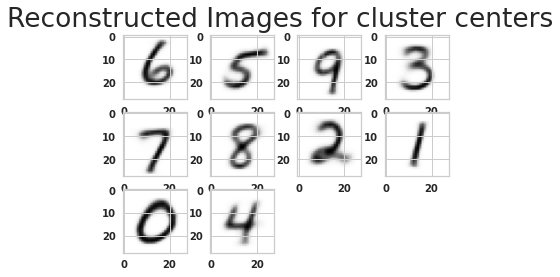

In [ ]:
import cv2
manual_annotation_json = None
tf.reset_default_graph()
# Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(
                                                                                    MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    10,
                                                                                    latent_vectors,
                                                                                    _exp_config,
                                                                                    _exp_config.dao
                                                                                    )
display_images(decoded_images, None, "Reconstructed Images for cluster centers", 10)


In [ ]:
# Investigate why 5 is wrong
import json
# TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 5, 9, 3,
                                           7, 8, 2, 1,
                                           0, 4
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]
manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
manual_annotation_json["posterior_proba"] = posterior_proba.tolist()


manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])
df[cluster_column_name] = cluster_labels

Getting manual_annotation


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


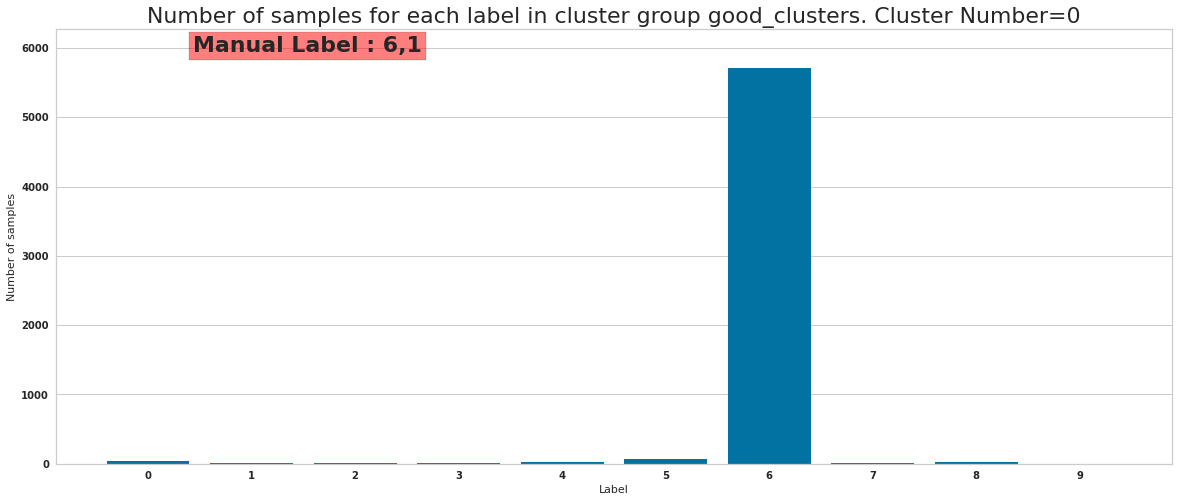

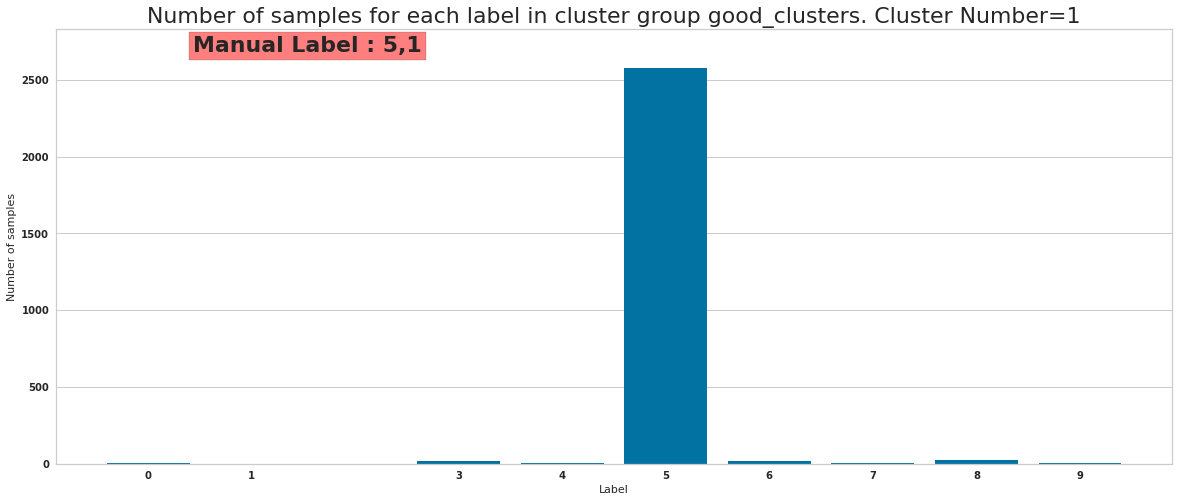

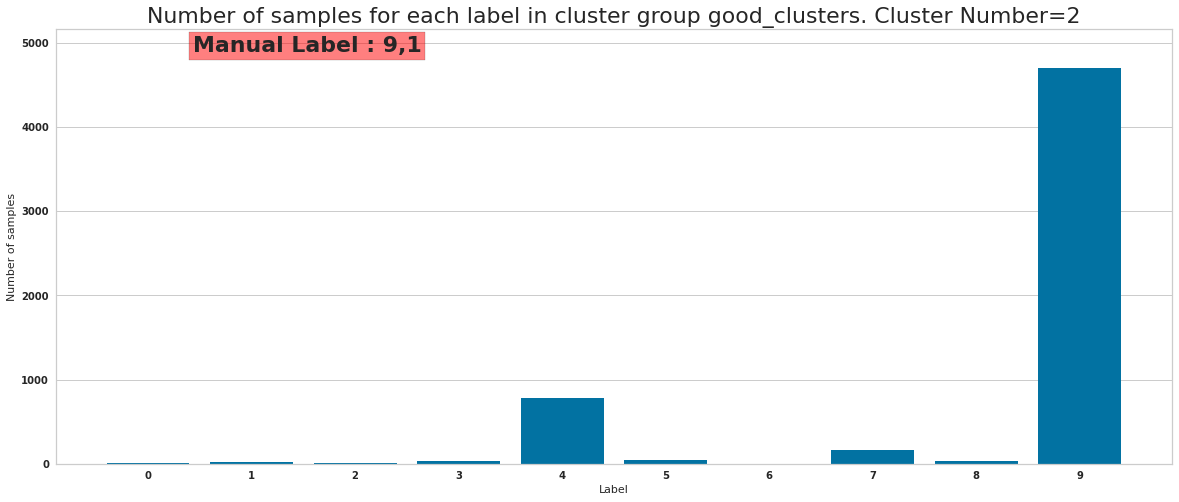

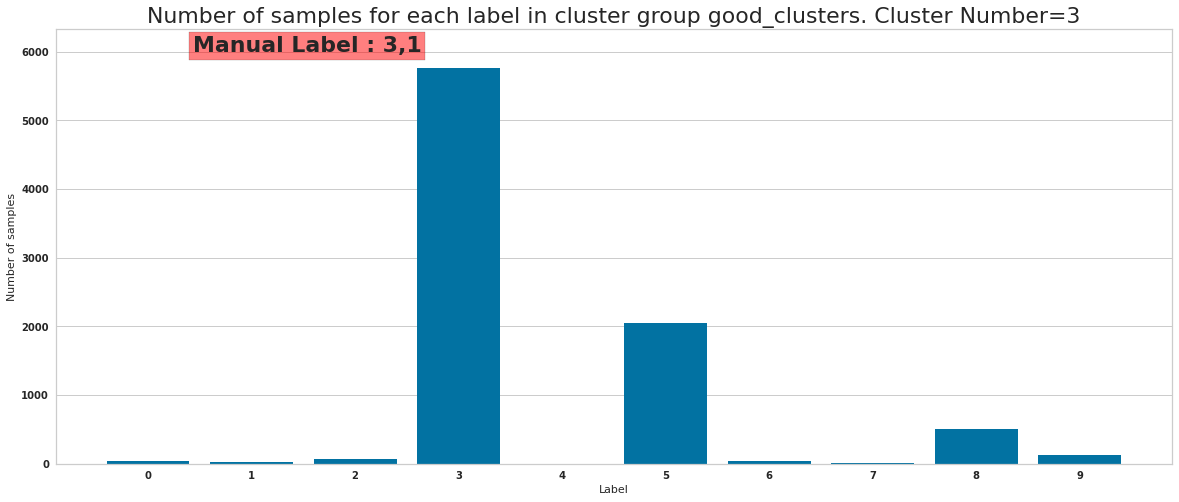

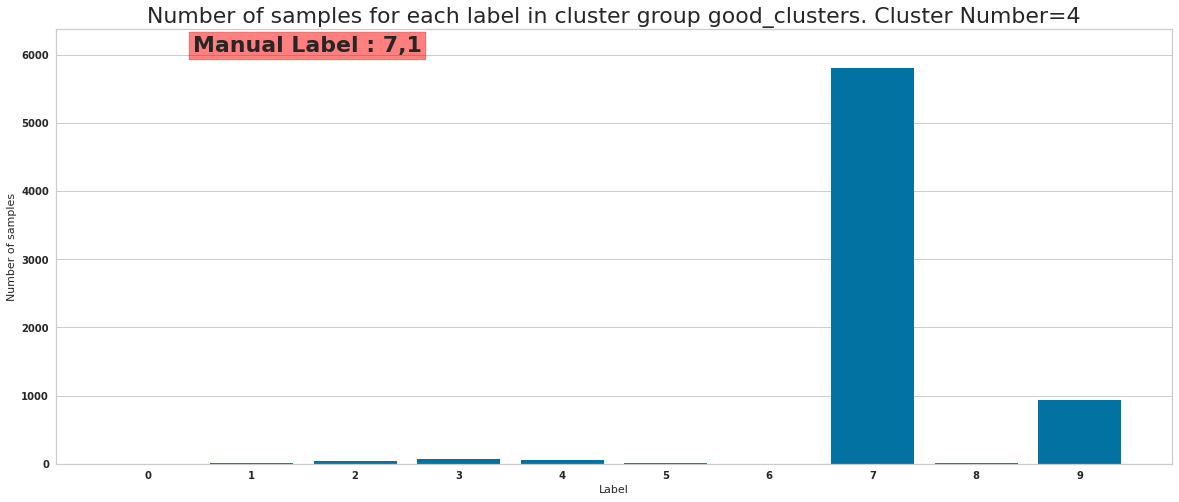

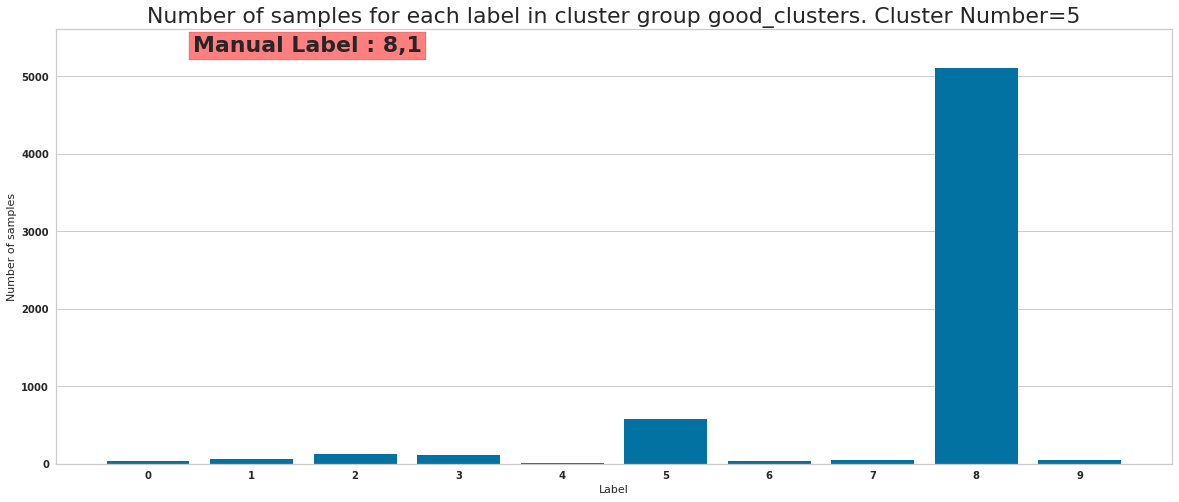

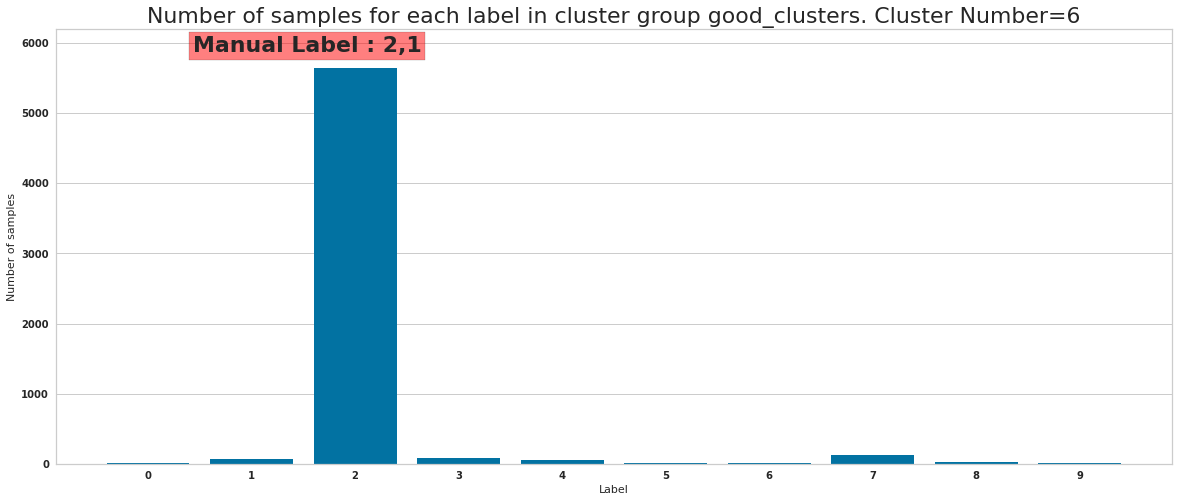

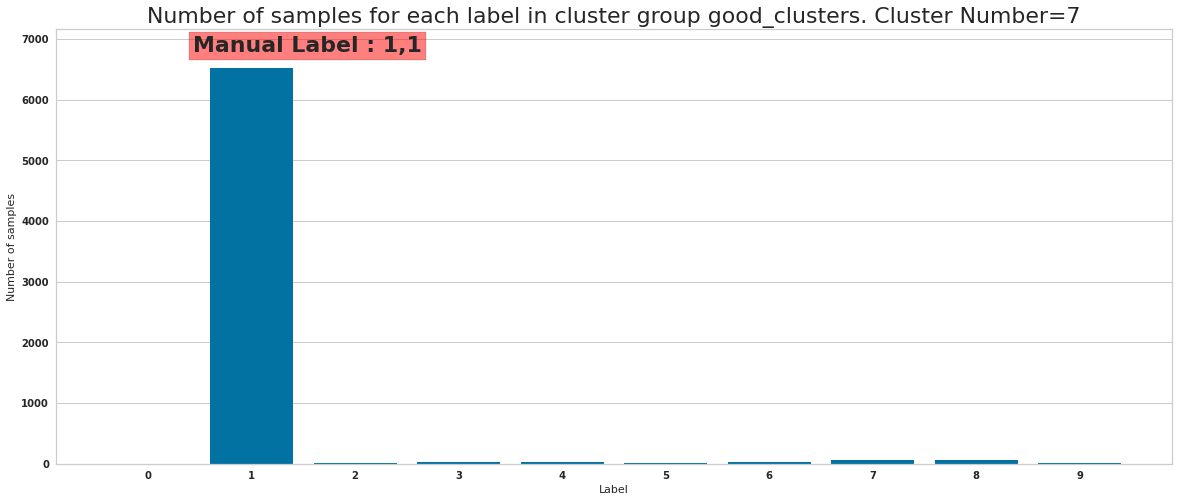

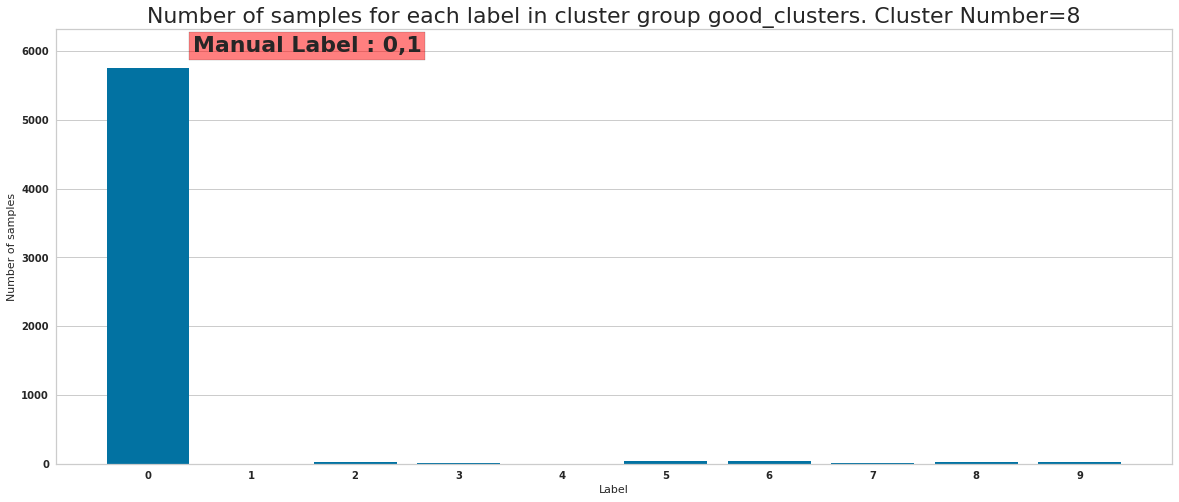

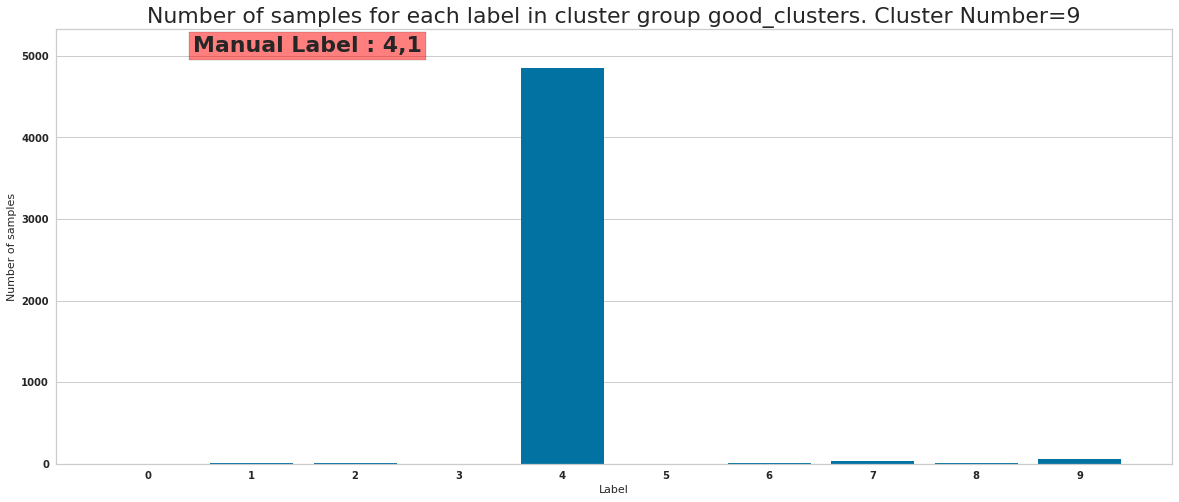

In [ ]:

from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance, cluster_and_decode_latent_vectors_gmm

cluster_group_dict = get_cluster_groups(manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(_exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 
level2_manual_annotations = cluster_next_level_gmm(_exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   _exp_config.dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

(5918, 16)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(2646, 16)
(5789, 16)
(8614, 16)
(6948, 16)
(6169, 16)
(6033, 16)
(6766, 16)
(5909, 16)
(4984, 16)
Posterior probability shape (59776, 10)


In [ ]:


# level_2_cluster_dict = level2_manual_annotations[2]
# level_2_cluster_dict["manual_labels"] = [
#                                          -1, -1,-1,-1,
#                                         -1,-1,-1,-1,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0,
#                                               0, 0, 0, 0,
#                                               0, 0
#                                               ]


# level_2_cluster_dict = level2_manual_annotations[5]
# level_2_cluster_dict["manual_labels"] = [-1,9,9,7,
#                                         9,9,9,-1,
#                                          9,9
#                                          ]

# level_2_cluster_dict["manual_confidences"] = [0, 0.9, 0.9, 0.7,
#                                               0.9, 0.9, 0.9, 0,
#                                               0.9, 0.9
#                                              ]


# level_2_cluster_dict = level2_manual_annotations[6]
# level_2_cluster_dict["manual_labels"] = [-1,-1,-1,-1,
#                                          -1,-1,-1,-1,
#                                          -1,-1
#                                          ]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0,
#                                               0, 0, 0, 0,
#                                               0, 0
#                                              ]


#### 9 ###############################################
# level_2_cluster_dict = level2_manual_annotations[9]
# level_2_cluster_dict["manual_labels"] = [9,-1,-1,-1,
#                                          9,-1,9,9,
#                                          -1,-1
#                                          ]
# level_2_cluster_dict["manual_confidences"] =  [0.8,0, 0, 0,
#                                                0.8,0,0.8,0.8,
#                                                0,0
#                                                ]


# level_2_cluster_dict = level2_manual_annotations[8]
# level_2_cluster_dict["manual_labels"] = [-1, -1, 8, 8,
#                                         5, 5, 5, -1,
#                                         8,8
#                                          ]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0.9, 0.9,
#                                               0.7, 0.7, 0.7, 0,
#                                               0.9, 0.9
#                                              ]



# level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
#                                            f"level_2_manual_annotation_epoch_{epochs_completed}.json")

# with open(level_2_manual_annotation_file_json, "w") as json_file:
#     json.dump(level2_manual_annotations, json_file)


In [ ]:
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

Posterior probability shape (59776, 10)


In [ ]:
process_second_level_clusters(df,
                              cluster_group_dict,
                              level2_manual_annotations,
                              z_col_names,
                              cluster_column_name_2,
                              cluster_column_name
                              )
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

Setting  next_level_clusters attribute to each primary cluster
Computing distances from second level cluster centers
Manual Label 6
(5918, 85) (5918, 82)
Num correct=5703
Cluster 0 Manual Label 6 Percentage correct 96.36701588374451
********************************
Manual Label 5
(2646, 85) (2646, 82)
Num correct=2574
Cluster 1 Manual Label 5 Percentage correct 97.27891156462584
********************************
Manual Label 9
(5789, 85) (5789, 82)
Num correct=4694
Cluster 2 Manual Label 9 Percentage correct 81.0848160304025
********************************
Manual Label 3
(8614, 85) (8614, 82)
Num correct=5757
Cluster 3 Manual Label 3 Percentage correct 66.83306245646622
********************************
Manual Label 7
(6948, 85) (6948, 82)
Num correct=5801
Cluster 4 Manual Label 7 Percentage correct 83.49165227403569
********************************
Manual Label 8
(6169, 85) (6169, 82)
Num correct=5101


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

Cluster 5 Manual Label 8 Percentage correct 82.6876317069217
********************************
Manual Label 2
(6033, 85) (6033, 82)
Num correct=5636
Cluster 6 Manual Label 2 Percentage correct 93.41952594065971
********************************
Manual Label 1
(6766, 85) (6766, 82)
Num correct=6517
Cluster 7 Manual Label 1 Percentage correct 96.31983446644989
********************************
Manual Label 0
(5909, 85) (5909, 82)
Num correct=5747
Cluster 8 Manual Label 0 Percentage correct 97.25841936029785
********************************
Manual Label 4
(4984, 85) (4984, 82)
Num correct=4845
Cluster 9 Manual Label 4 Percentage correct 97.21107544141252
********************************
Total number of individual samples annotated 0


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


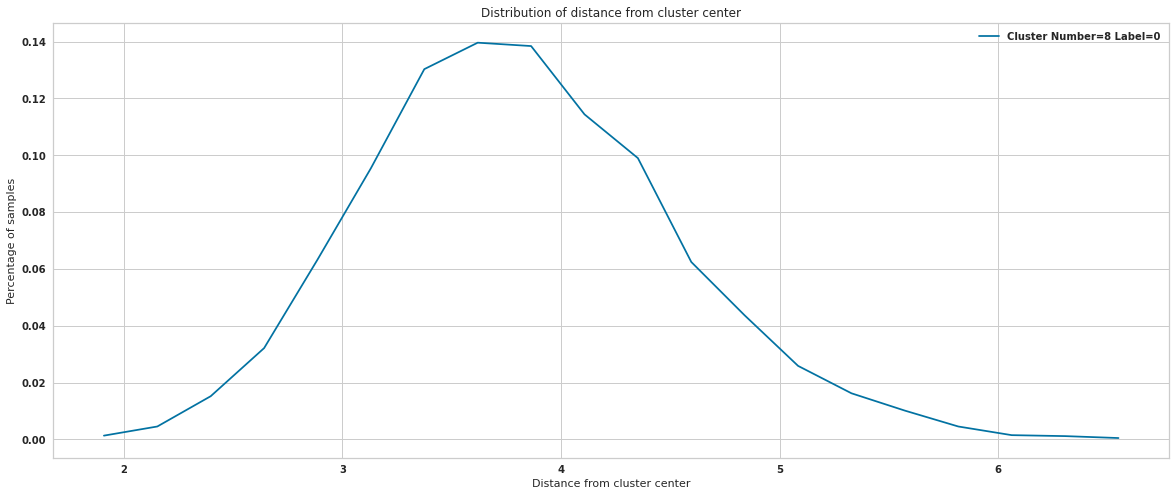

In [ ]:
plot_distance_distribution(df, [8], cluster_column_name, manual_labels)

In [ ]:
# Take samples from each distance - 0 ( cluster center), 0.5, 1, 1,5, 2, 2,5, 3, 3,5,......10]
# show sample images from each distance and manually decide the threshold
# Iterator over each distance from (0, 10, 0.5)
# comuter the cluster center and plot how much the cluster changes over each iteration
# Do one level of k-means clustring and look the good and bad cluster - compute the distance from level 1 cluser to each of level 2 cluster



In [ ]:
print([c.id for c in cluster_group_dict["good_clusters"].cluster_list])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
cluster_group_dict = get_cluster_groups(manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 
cluster_group_dict["good_clusters"].cluster_list


In [ ]:
MAX_IMAGES_TO_DISPLAY=36

In [ ]:
images_by_label = dict()
latent_vectors_by_label = dict()
for i in range(10):
    images_by_label[i] = train_images[train_labels == i]
    latent_vectors_by_label[i] = latent_vectors[train_labels == i]

In [ ]:
def get_digit_label(cluster_name:str):
    if cluster_name.startswith("level_2_cluster_centers"):
        cluster_id = int(cluster_name.rsplit("_", 1)[1])
        return manual_labels[cluster_id]
    elif cluster_name.startswith("training_set"):
        return int(cluster_name.rsplit("_", 1)[1])


# Start segmentation
## Criteria for manual selection
*  Image is straight and vertical
*  All all features clearyly vision

In [ ]:
manual_label_to_cluster_id_map = dict()

for manual_label in manual_labels:
    level_1_clluster = np.where(np.asarray(manual_labels) == manual_label)
    cluster_id = level_1_clluster[0][0]
    manual_label_to_cluster_id_map[manual_label] = cluster_id


# Cluster good clusters in first level cluster

In [ ]:
level2_manual_annotations_good_cluster:Dict[int, Dict] = dict()
level2_manual_annotations_good_cluster = cluster_next_level_gmm(_exp_config,
                                                df,
                                                cluster_column_name_2,
                                                df[cluster_column_name],
                                                model_type,
                                                epochs_completed,
                                                _exp_config.dao,
                                                cluster_group_dict,
                                                cluster_type="good_clusters",
                                                num_clusters=20,
                                                show_images=False
                                                )
with open(_exp_config.ANALYSIS_PATH + "level2_manual_annotations_good_cluster.json", "w") as json_file:
    json.dump(level2_manual_annotations_good_cluster, json_file)


0 6
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(5918, 20) (5918,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

1 5
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(2646, 20) (2646,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

2 9
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(5789, 20) (5789,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

3 3
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(8614, 20) (8614,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

4 7
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(6948, 20) (6948,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

5 8
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(6169, 20) (6169,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

6 2
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(6033, 20) (6033,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

7 1
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(6766, 20) (6766,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

8 0
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(5909, 20) (5909,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

9 4
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.mode

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

(4984, 20) (4984,)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
image_set_dict = dict()
for cluster_id in range(num_clusters):
    image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = np.asarray(level2_manual_annotations_good_cluster[cluster_id]["decoded_images"])
    image_set_dict[f"training_set_{cluster_id}"] = images_by_label[cluster_id]


In [ ]:
image_list:Dict[int, np.ndarray] = dict()
image_segments:Dict[int, np.ndarray] = dict()

## Digit 8

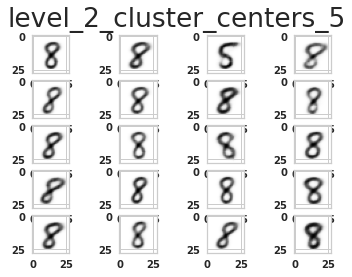

Number of image is 5832. Displaying only first 36 images 


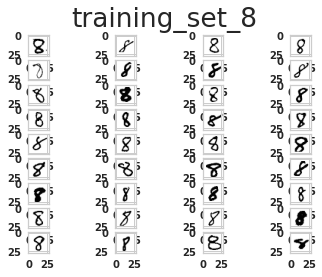

In [ ]:
digit = 8
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 2
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
h_extend = [ 13, 26]
v_extend = [0,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = [ 0, 15]
v_extend = [0,28]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = []
v_extend = [13, 28]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_expted = [ ]
v_extend = [0, 13]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 4
7
Image shape (28, 28, 1)
[13, 26] [0, 28] (28, 28, 1)
13 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
7
Image shape (28, 28, 1)
[0, 15] [0, 28] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [13, 28] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [0, 13] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_8.png


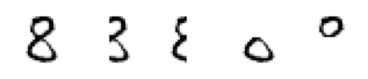

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 7

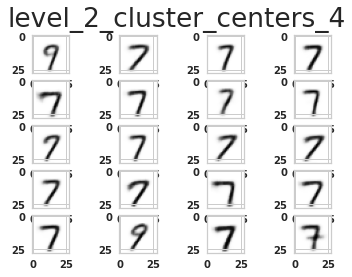

Number of image is 6244. Displaying only first 36 images 


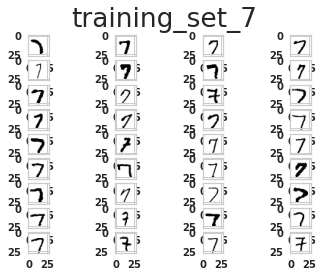

In [ ]:
digit = 7
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
start_index = 0
offset = 2
sample_index = start_index + offset
# cluster_name = "training_set"
#if choosing from cluster, chnage the digit

cluster_name = f"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"

digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
h_extend = [ ]
v_extend = [0, 12]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = [ ]
v_extend = [12, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [0, 12] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [12, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_7.png


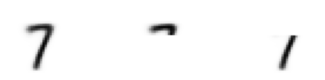

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 6

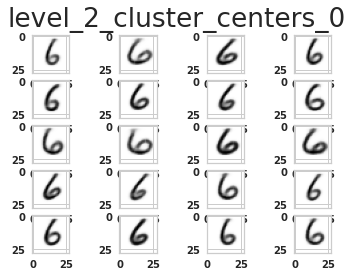

Number of image is 5896. Displaying only first 36 images 


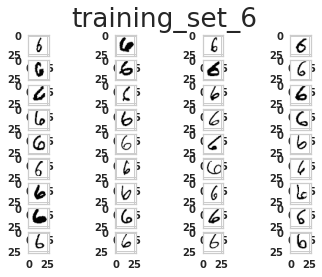

In [ ]:
digit = 6
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )


In [ ]:
offset = 3
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
# image_segments = segment( digit_image, h_extend = [ ], v_extend = [0,12], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#                         cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [0, 12]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [12,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,                cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [12,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [0, 12] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [12, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_6.png


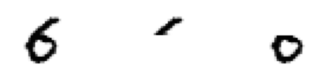

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 5

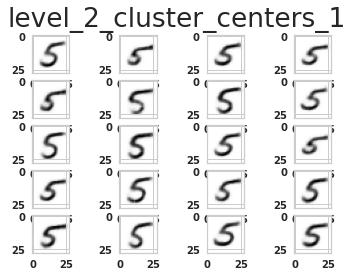

Number of image is 5402. Displaying only first 36 images 


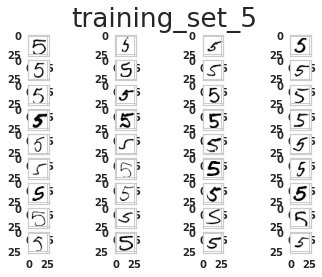

In [ ]:
digit = 5
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 4
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [5, 11], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#                               cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [5, 11]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
# image_segments = segment( digit_image, h_extend = [ ], v_extend = [11, 28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,                        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [11,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 11] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [11, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_5.png


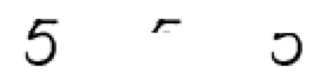

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 4

### 4 has bimodel distribution. So take two samples from each mode

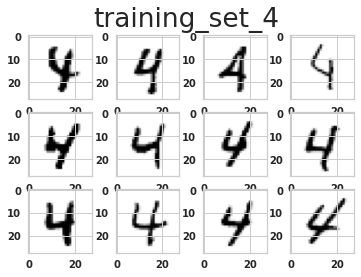

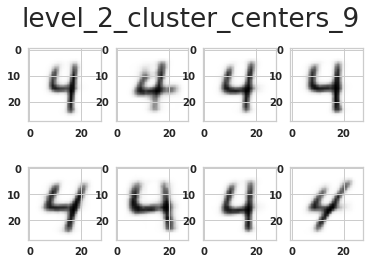

In [ ]:
digit = 4
start_index = 12
NUM_IMAGES_IN_SINGLE_PLOT = 12
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set[start_index:start_index + NUM_IMAGES_IN_SINGLE_PLOT],
                   None,
                   cluster_name
                   )

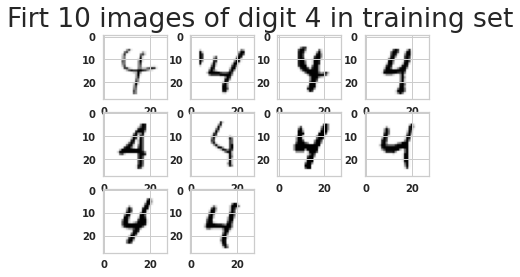

In [ ]:
display_images(images_by_label[digit][10:20,:,:,:], None, f"Firt 10 images of digit {digit} in training set", 10)

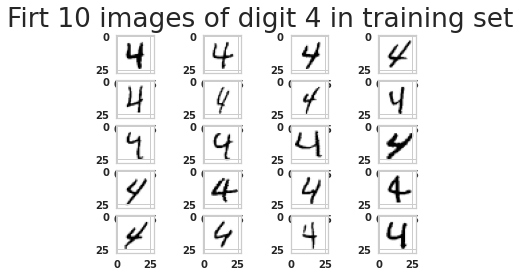

In [ ]:
start_index = 20
display_images(images_by_label[digit][start_index:40,:,:,:], None, f"Firt 10 images of digit {digit} in training set")

In [ ]:
offset = 1
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [15, 18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [15, 18]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
# left veritical line
#image_segments = segment( digit_image, h_extend = [13,16 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config, cluster=cluster_name, sample_index=sample_index)

h_extend = [13, 16]
v_extend = []
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
# middle veritical line
# image_segments = segment( digit_image, h_extend = [14,17 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config, cluster=cluster_name, sample_index=sample_index)

h_extend = [14,17 ]
v_extend = []
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 3
7
Image shape (28, 28, 1)
[0, 28] [15, 18] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[13, 16] [0, 28] (28, 28, 1)
13 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
7
Image shape (28, 28, 1)
[14, 17] [0, 28] (28, 28, 1)
14 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_4_training_set_4_21.png


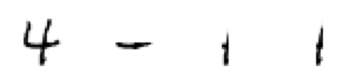

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

### 2nd mode of 4

In [ ]:
#Cleare the previsous image result of 4
image_list[digit] = []

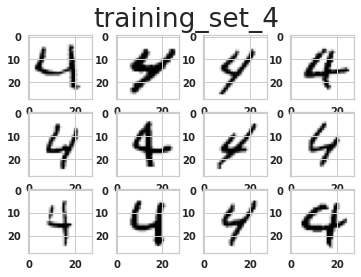

<Figure size 432x288 with 0 Axes>

In [ ]:
start_index = 30
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set[start_index:start_index + NUM_IMAGES_IN_SINGLE_PLOT],
                   None,
                   cluster_name
                   )

In [ ]:
offset = 9
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [5,18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name,
#        sample_index=sample_index)

h_extend = [ ]
v_extend = [5, 17]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
# image_segments = segment( digit_image, h_extend = [ 17,23 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name,
#        sample_index=sample_index)

h_extend = [ 17, 23]
v_extend = [17, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 17] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[17, 23] [17, 28] (28, 28, 1)
17 14.0 5.6000000000000005
Starts from middle on horizontal axis
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_4_training_set_4_39.png


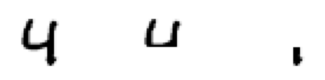

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 3

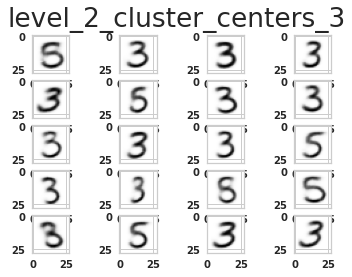

Number of image is 6111. Displaying only first 36 images 


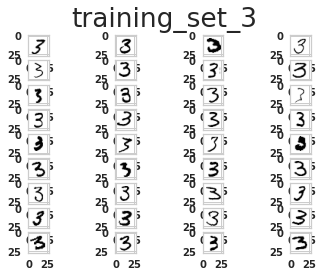

In [ ]:
digit = 3
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 6
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [5,16], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [5, 16]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [16,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [16, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 16] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [16, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_3.png


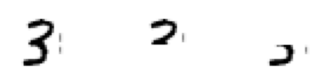

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 2

Number of image is 5932. Displaying only first 36 images 


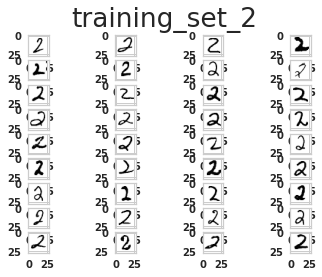

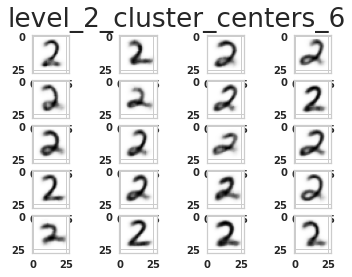

In [ ]:
digit = 2
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

### 2 is bimodal

In [ ]:
offset = 5
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [3,18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

# Looks like a hook, question mark with dot removed

h_extend = [ ]
v_extend = [3, 18]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [18,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [18, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 18] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [18, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_2_training_set_2_5.png


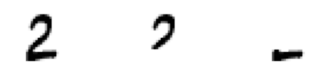

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

### 2nd mode of 2

In [ ]:
#Cleare the previsous image result of 2
image_list[digit] = []

Number of image is 5932. Displaying only first 10 images 


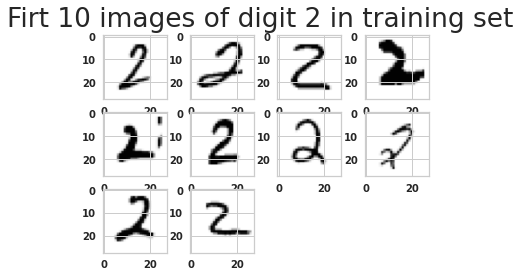

In [ ]:
display_images(images_by_label[digit], None, f"Firt 10 images of digit {digit} in training set", 10)

In [ ]:
offset = 6
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 

In [ ]:
# image_segments = segment( digit_image,
#         h_extend = [],
#         v_extend = [3,15],
#         digit = digit,
#         num_clusters=num_clusters ,
#         exp_config=_exp_config,
#         cluster=cluster_name,
#         sample_index=sample_index
#         )

h_extend = [ ]
v_extend = [3,15]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
# image_segments = segment( digit_image,
#                          h_extend = [],
#                          v_extend = [15, 28],
#                          digit = digit,
#                          num_clusters=num_clusters,
#                          exp_config=_exp_config,
#                          cluster=cluster_name,
#                          sample_index=sample_index
#                          )

h_extend = [ ]
v_extend = [15, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 15] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [15, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_2_training_set_2_6.png


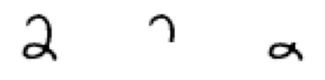

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 9

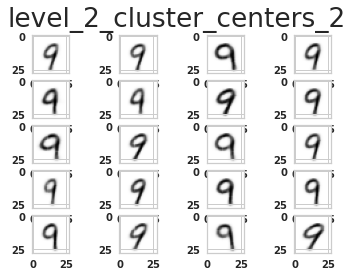

Number of image is 5923. Displaying only first 36 images 


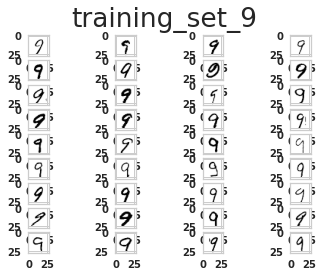

In [ ]:
digit = 9
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 4
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [3,17], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [3, 17]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
#image_segments=segment( digit_image, h_extend = [], v_extend = [17,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [17, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 17] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [17, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/Concepts_from_class_9.png


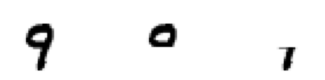

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

# Digit 0

Number of image is 5900. Displaying only first 36 images 


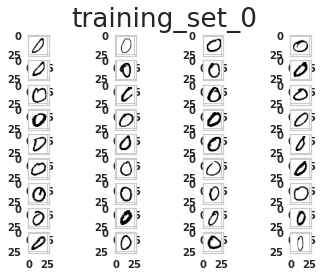

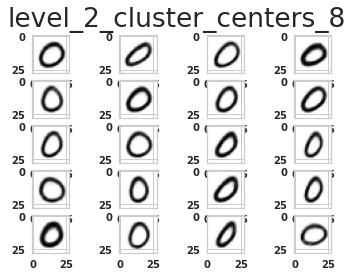

In [ ]:
digit = 0
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
from clearn.models.generative_model import GenerativeModel

In [ ]:
def decode_and_get_features(model: GenerativeModel, z: np.ndarray, batch_size: int):
    feature_dimension = [len(z), model.dao.image_shape[0], model.dao.image_shape[1], model.dao.image_shape[2]]
    reconstructed_images = np.zeros(feature_dimension)
    num_latent_vectors = z.shape[0]
    num_batches = num_latent_vectors // batch_size
    dense1_des = []
    dense2_des = []
    reshaped_des = []
    deconv1_des = []
    features_dict = dict()
    for batch_num in range(num_batches):
        feature_names, decoded_images_and_features = model.decode_and_get_features(z[batch_num * batch_size: (batch_num + 1) * batch_size])
        reconstructed_images[batch_num * batch_size: (batch_num + 1) * batch_size] = decoded_images_and_features[0]
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                print(decoded_images_and_features[i + 1].shape)
                features_dict[feature_name] = np.zeros([len(z),
                                                       decoded_images_and_features[i + 1].shape[1],
                                                       decoded_images_and_features[i + 1].shape[2],
                                                       decoded_images_and_features[i + 1].shape[3]]
                                                       )
            features_dict[feature_name][batch_num * batch_size: (batch_num + 1) * batch_size] = decoded_images_and_features[i + 1]

    left_out = num_latent_vectors % batch_size
    if left_out > 0:
        last_batch = np.zeros([batch_size, z.shape[1]])
        last_batch[0:left_out, :] = z[num_batches * batch_size:]
        feature_names, decoded_images_and_features = model.decode_and_get_features(last_batch)
        reconstructed_images[num_batches * batch_size:] = decoded_images_and_features[0][0:left_out]
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                features_dict[feature_name] = np.zeros([len(z),
                                                       decoded_images_and_features[i + 1].shape[1],
                                                       decoded_images_and_features[i + 1].shape[2],
                                                       decoded_images_and_features[i + 1].shape[3]]
                                                       )
            features_dict[feature_name][num_batches * batch_size:] = decoded_images_and_features[i + 1][0:left_out]

        
    return feature_names, reconstructed_images, features_dict

In [ ]:
def encode_and_get_features(model: SemiSupervisedClassifierMnist,
                            images, batch_size, z_dim):
    num_images = images.shape[0]
    num_batches = num_images // batch_size
    mus = np.zeros([len(images), z_dim])
    sigmas = np.zeros([len(images), z_dim])
    latent_vectors = np.zeros([len(images), z_dim])
    features_dict = dict()

    for batch_num in range(num_batches):
        feature_names, mu, sigma, z, encoded_features = model.encode_and_get_features(
            images[batch_num * batch_size: (batch_num + 1) * batch_size])
        mus[batch_num * batch_size: (batch_num + 1) * batch_size] = mu
        sigmas[batch_num * batch_size: (batch_num + 1) * batch_size] = sigma
        latent_vectors[batch_num * batch_size: (batch_num + 1) * batch_size] = z
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                print(encoded_features[i].shape)
                features_dict[feature_name] = np.zeros([len(z),
                                                       encoded_features[i].shape[1],
                                                       encoded_features[i].shape[2],
                                                       encoded_features[i].shape[3]]
                                                       )
            features_dict[feature_name][batch_num * batch_size: (batch_num + 1) * batch_size] = encoded_features[i]


    left_out = num_images % batch_size
    if left_out > 0:
        feature_dimension = [batch_size, model.dao.image_shape[0], model.dao.image_shape[1], model.dao.image_shape[2]]
        last_batch = np.zeros(feature_dimension)
        last_batch[0:left_out] = images[num_batches * batch_size:]
        feature_names, mu, sigma, z, encoded_features = model.encode_and_get_features(last_batch)
        mus[num_batches * batch_size:] = mu[0:left_out]
        sigmas[num_batches * batch_size:] = sigma[0:left_out]
        latent_vectors[num_batches * batch_size:] = z[0:left_out]
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                print(encoded_features[i].shape)
                features_dict[feature_name] = np.zeros([len(z),
                                                       encoded_features[i].shape[1],
                                                       encoded_features[i].shape[2],
                                                       encoded_features[i].shape[3]]
                                                       )
            features_dict[feature_name][num_batches * batch_size:] = encoded_features[i]

        

    return mus, sigmas, latent_vectors, features_dict


In [ ]:
# indices_of_similar_images =[0, 3, 7, 9]
# latent_vectors_6_reshaped_similar = latent_vectors_6_reshaped[indices_of_similar_images]
# display_images(latent_vectors_6_reshaped_similar, None, "Latent Images for digit 6", 10)
# display_images(np.squeeze(reconstructed_images_6), None, "Reconstructed image for digit 6", 10)
# for layer_num in range(4):
#   display_images(np.squeeze(features_dict[feature_names[layer_num]][:,:,:,0]),
#                 None,
#                 f"Decoder hidden layer {layer_num} Images for cluster center",
#                 10)


In [ ]:
def display_images(decoded_images,
                   image_filename,
                   title,
                   num_images_to_display = 0,
                   fig_size=None,
                   axis = None,
                   num_cols=4,
                   ):

    colormap = "Greys"
    if fig_size is not None:
        fig = plt.figure(figsize=fig_size, constrained_layout=True)
    else:
        fig = plt.figure()
    fig.tight_layout()
    num_images = len(decoded_images)
    if num_images_to_display == 0:
        num_images_to_display = min(num_images, MAX_IMAGES_TO_DISPLAY)
    elif num_images_to_display > 0:
        num_images_to_display = min(num_images_to_display, MAX_IMAGES_TO_DISPLAY, num_images )
    else:
        raise Exception("num_images_to_display should not be negative")
    if num_images >  num_images_to_display:
        print(f"Number of image is {num_images}. Displaying only first {num_images_to_display} images ")
    num_rows = math.ceil(num_images_to_display / num_cols)
    if title is not None and len(title) > 0:
        fig.suptitle(title)
    for i in range(num_images_to_display):
        ax = fig.add_subplot(num_rows, num_cols, i + 1)
        ax.imshow(np.squeeze(decoded_images[i]), cmap=colormap)
        if axis is not None:
            ax.axis(axis)
    if image_filename is not None and len(image_filename) > 0:
        print(f"Saving the image to {image_filename}")
        plt.savefig(image_filename,
                    bbox="tight",
                    pad_inches=0
                    )
    plt.show()


# Reconstruction of segments 

In [ ]:
from copy import copy
def display_images_lv_reconstructed(exp_config,
                                    image_segments_set_1,
                                    file_identifier = None):
    
    tf.reset_default_graph()
    if file_identifier is not None:
        file_name = _exp_config.ANALYSIS_PATH  + f"manual_concepts_{file_identifier}.pdf"
    display_images(image_segments_set_1,
                file_name,
                "Manually obtained concepts from images 2 to 4",
                num_cols=image_segments_set_1.shape[0],
                axis="off",
                fig_size = (5, 2) 
                )

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = _exp_config.dao,
                        exp_config=_exp_config,
                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                        num_epochs=1,
                        sess=sess,
                        test_data_iterator=None,
                        train_val_data_iterator=None
                        )
        mu, sigms, z, features_dict = encode_and_get_features(model,
                                                            image_segments_set_1,
                                                            _exp_config.BATCH_SIZE,
                                                            _exp_config.Z_DIM
                                                            )
        if file_identifier is not None:
            file_name = _exp_config.ANALYSIS_PATH  + f"manual_concepts_{file_identifier}.pdf"

        display_images(np.reshape(z, (image_segments_set_1.shape[0], 4, 4 )),
                _exp_config.ANALYSIS_PATH + "Latent_images.pdf",
                "Latent images",
                axis="off",
                num_cols=image_segments_set_1.shape[0],
                fig_size = (5, 2)
                )
        
        feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                            z,
                                                            _exp_config.BATCH_SIZE
                                                            )
    images_to_display = [img for img in image_segments_set_1]
    #lv_as_list = [lv for lv in np.reshape(z, (image_segments_set_1.shape[0], 4, 4))] 
    print(image_segments_set_1[0].shape)
    # images_to_display.extend( lv_as_list)
    if file_identifier is not None:
        filename =_exp_config.ANALYSIS_PATH + f"reconstructed_images_{file_identifier}.pdf"
    display_images(reconstructed_images,
                filename,
                "Reconstructed Images",
                axis="off",
                num_cols=image_segments_set_1.shape[0],
                fig_size = (5, 2) 
                ) 
    print(z.shape)

In [ ]:
# def display_images(decoded_images,
#                    image_filename,
#                    title,
#                    num_images_to_display = 0,
#                    fig_size=None,
#                    axis = None,
#                    num_cols=4,
#                    ):


In [ ]:
!pwd

/content/gdrive/MyDrive/sunil/concept_learning/concept_learning


## Manually generated concepts and their reconstructed images

In [ ]:
def reconstruct_concpets(model: SemiSupervisedClassifierMnist,
                            images, batch_size, z_dim):
    num_images = images.shape[0]
    num_batches = num_images // batch_size
    mus = np.zeros([len(images), z_dim])
    sigmas = np.zeros([len(images), z_dim])
    latent_vectors = np.zeros([len(images), z_dim])
    features_dict = dict()

    for batch_num in range(num_batches):
        feature_names, mu, sigma, z, encoded_features = model.encode_and_get_features(
            images[batch_num * batch_size: (batch_num + 1) * batch_size])
        mus[batch_num * batch_size: (batch_num + 1) * batch_size] = mu
        sigmas[batch_num * batch_size: (batch_num + 1) * batch_size] = sigma
        latent_vectors[batch_num * batch_size: (batch_num + 1) * batch_size] = z
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                print(encoded_features[i].shape)
                features_dict[feature_name] = np.zeros([len(z),
                                                       encoded_features[i].shape[1],
                                                       encoded_features[i].shape[2],
                                                       encoded_features[i].shape[3]]
                                                       )
            features_dict[feature_name][batch_num * batch_size: (batch_num + 1) * batch_size] = encoded_features[i]


    left_out = num_images % batch_size
    if left_out > 0:
        feature_dimension = [batch_size, model.dao.image_shape[0], model.dao.image_shape[1], model.dao.image_shape[2]]
        last_batch = np.zeros(feature_dimension)
        last_batch[0:left_out] = images[num_batches * batch_size:]
        feature_names, mu, sigma, z, encoded_features = model.encode_and_get_features(last_batch)
        mus[num_batches * batch_size:] = mu[0:left_out]
        sigmas[num_batches * batch_size:] = sigma[0:left_out]
        latent_vectors[num_batches * batch_size:] = z[0:left_out]
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                print(encoded_features[i].shape)
                features_dict[feature_name] = np.zeros([len(z),
                                                       encoded_features[i].shape[1],
                                                       encoded_features[i].shape[2],
                                                       encoded_features[i].shape[3]]
                                                       )
            features_dict[feature_name][num_batches * batch_size:] = encoded_features[i]

        

    return mus, sigmas, latent_vectors, features_dict


(6, 28, 28, 1)
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/manual_concepts_2_3_4.pdf


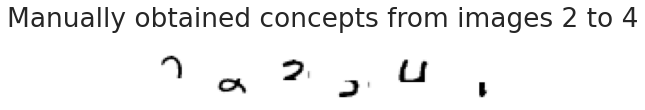

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

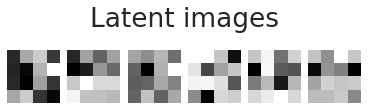

(28, 28, 1)
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/reconstructed_images_2_3_4.pdf


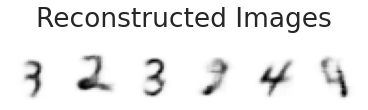

(6, 16)


In [ ]:
digits = [2, 3, 4]

image_segments_set_1 = copy(image_segments[digits[0]])
for digit in digits[1:]:
    image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[digit]])

print(image_segments_set_1.shape)
file_identifier = str(digits[0])
for digit in digits[1:]:
    file_identifier += f"_{digit}"
display_images_lv_reconstructed(_exp_config, image_segments_set_1, "2_3_4")

(6, 28, 28, 1)
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/manual_concepts_5_6_7.pdf


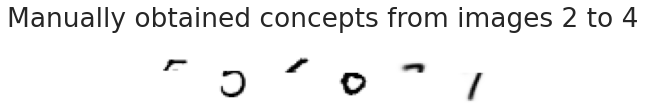

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

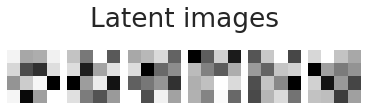

(28, 28, 1)
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/reconstructed_images_5_6_7.pdf


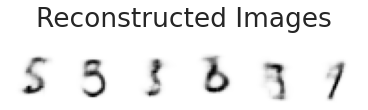

(6, 16)


In [ ]:
digits = [5,6,7]

image_segments_set_1 = copy(image_segments[digits[0]])
for digit in digits[1:]:
    image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[digit]])

print(image_segments_set_1.shape)
file_identifier = str(digits[0])
for digit in digits[1:]:
    file_identifier += f"_{digit}"
display_images_lv_reconstructed(_exp_config, image_segments_set_1, file_identifier)

(4, 28, 28, 1)
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/manual_concepts_8.pdf


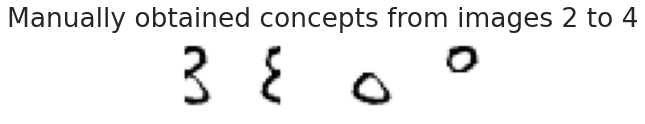

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

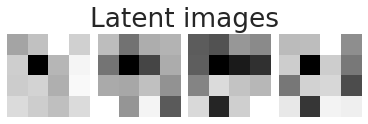

(28, 28, 1)
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/analysis/reconstructed_images_8.pdf


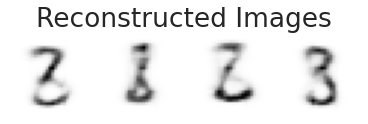

(4, 16)


In [ ]:
digits = [8]

image_segments_set_1 = copy(image_segments[digits[0]])
for digit in digits[1:]:
    image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[digit]])

print(image_segments_set_1.shape)
file_identifier = str(digits[0])
for digit in digits[1:]:
    file_identifier += f"_{digit}"
display_images_lv_reconstructed(_exp_config, image_segments_set_1, file_identifier)

# Analyze latent image

In [ ]:
def combine_digits_old(exp_config, d1, d2, manual_labels, cluster_centers_reshaped):
  six_index = manual_labels.index(d1)
  one_index = manual_labels.index(d2)

  one_top = cluster_centers_reshaped[one_index][0:2, :]
  one_bottom = cluster_centers_reshaped[one_index][2:, :]

  six_top= cluster_centers_reshaped[six_index][0:2, :]

  six_bottom= cluster_centers_reshaped[six_index][2:, :]

  one_and_six = np.reshape(np.vstack((one_top, six_bottom)), (1,16))
  six_and_one = np.reshape(np.vstack((six_top, one_bottom)), (1,16))
  six_and_six = np.reshape(np.vstack((six_top, six_bottom)), (1,16))
  one_and_one = np.reshape(np.vstack((one_top, one_bottom)), (1,16))

  combined = np.concatenate((  six_and_one, one_and_six, one_and_one, six_and_six)
  )
  tf.reset_default_graph()

  with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
      model = get_model(dao = exp_config.dao,
        exp_config=exp_config,
        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
        num_epochs=1,
        sess=sess,
        test_data_iterator=None,
        train_val_data_iterator=None)

      one_and_six_reconstructed = decode(model,
                                        combined,
                                        exp_config.BATCH_SIZE
                                        )
      display_images(one_and_six_reconstructed, None, f"Top half of {d1} and bottom half of {d2}")

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

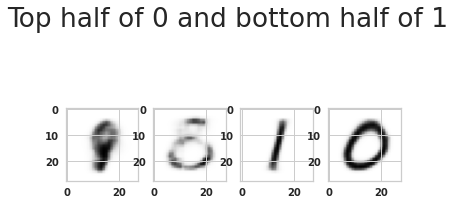

In [ ]:
cluster_centers_reshaped = np.reshape(cluster_centers, (num_clusters, 4, 4))

digits = [0,1]
combine_digits_old(_exp_config, digits[0], digits[1], manual_labels, cluster_centers_reshaped)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

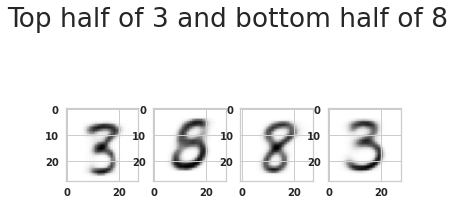

In [ ]:
cluster_centers_reshaped = np.reshape(cluster_centers, (num_clusters, 4, 4))
digits = [3,8]
combine_digits_old(_exp_config, digits[0], digits[1], manual_labels, cluster_centers_reshaped)

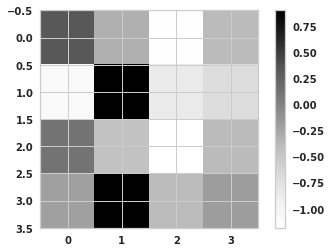

In [ ]:

#display_images(cluster_centers_reshaped, None, "Latent Images for cluster center")
plt.imshow(cluster_centers_reshaped[manual_labels.index(3)])
plt.colorbar()

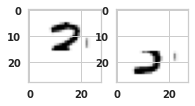

In [ ]:
digit = 3
display_images(np.squeeze(image_segments[digit]), None, None )

# Define class ImageConcept

In [ ]:
class ImageConcept:
    def __init__(self,
                 digit_image:np.ndarray,
                 h_extend:List,
                 v_extend:List,
                 digit:int,
                 num_clusters:int,
                 cluster_name:str,
                 sample_index:int):
        self.digit_image = digit_image
        self.h_extend = h_extend
        self.v_extend = v_extend
        self.digit = digit
        self.num_clusters = num_clusters
        self.cluster_name = cluster_name
        self.sample_index = sample_index

    def todict(self):
        concept_dict = dict()
        concept_dict["digit_image"] = self.digit_image.tolist()
        concept_dict["h_extend"] = self.h_extend
        concept_dict["v_extend"] = self.v_extend
        concept_dict["digit"] = self.digit
        concept_dict["num_clusters"] = self.num_clusters
        concept_dict["cluster_name"] = self.cluster_name
        concept_dict["sample_index"] = self.sample_index
        return concept_dict


In [ ]:
def create_concept_dict(image_list):
    concepts_dict = dict()
    for digit,  concepts in image_list.items():
        for concept in concepts:
            if digit in concepts_dict.keys():
                #print(digit)
                concept_dict = ImageConcept(concept[0],
                            concept[1],
                            concept[2],
                            concept[3],
                            concept[4],
                            concept[5],
                            concept[6]).todict()
                print(digit, concept_dict)
                concepts_dict[digit].append(concept_dict)
            else:
                concepts_dict[digit] = [ImageConcept(concept[0],
                                                    concept[1],
                                                    concept[2],
                                                    concept[3],
                                                    concept[4],
                                                    concept[5],
                                                    concept[6]).todict()
                
                ]
    return concepts_dict


# Printing concepts dictionary

In [ ]:
concepts_dict = create_concept_dict(image_list)

8 {'digit_image': [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.054901960784313725], [0.2627450980392157], [0.611764705882353], [0.6705882352941176], [0.996078431372549], [1.0], 

In [ ]:
print([k for k in concepts_dict.keys()])
print(concepts_dict[3])

[8, 7, 6, 5, 4, 3, 2, 9]
[{'digit_image': [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0

In [ ]:

concept_dict[3][0]["cluster_name"]



NameError: ignored

In [ ]:
import json

file_name = _exp_config.ANALYSIS_PATH + "manually_generated_concepts.json"
with open(file_name, "w") as json_file:
    json.dump(concept_dict, json_file)


In [ ]:
digits = [3 ,8]
digit = digits[0]
latent_vectors_dict = dict()
training_images_dict = dict()
for concept_no, concept in enumerate(concept_dict[digit]):
    print(concept_no)
    if concept.cluster_name == f"training_set_{digit}":
        latent_vectors_dict[f"{digit}_{concept_no}"] = latent_vectors_by_label[digit][concept.sample_index]
        training_images_dict[f"{digit}_{concept_no}"] = images_by_label[digit][concept.sample_index]

concept = concept_dict[digit][0]
digit_image = np.squeeze(concept.digit_image)

if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           )

plt.figure()

concept = concept_dict[3][1]
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

digit_image = np.squeeze(concept.digit_image)
plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           )


In [ ]:
digit = digits[1]

for concept_no, concept in enumerate(concept_dict[digit]):
    if concept.cluster_name == f"training_set_{digit}":
        latent_vectors_dict[f"{digit}_{concept_no}"] = latent_vectors_by_label[digit][concept.sample_index]
        training_images_dict[f"{digit}_{concept_no}"] = images_by_label[digit][concept.sample_index]

concept = concept_dict[digit][0]
digit_image = np.squeeze(concept.digit_image)
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           )


plt.figure()
concept = concept_dict[digit][1]
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

digit_image = np.squeeze(concept.digit_image)
plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           )

plt.figure()
concept = concept_dict[digit][2]
digit_image = np.squeeze(concept.digit_image)
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           )

plt.figure()
concept = concept_dict[digit][3]
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

digit_image = np.squeeze(concept.digit_image)
plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           
           )


NameError: ignored

In [ ]:
digit = digits[1]

for concept_no, concept in enumerate(concept_dict[digit]):
    if concept.cluster_name == f"training_set_{digit}":
        latent_vectors_dict[f"{digit}_{concept_no}"] = latent_vectors_by_label[digit][concept.sample_index]
        training_images_dict[f"{digit}_{concept_no}"] = images_by_label[digit][concept.sample_index]

concept = concept_dict[digit][0]
digit_image = np.squeeze(concept.digit_image)
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           )


plt.figure()
concept = concept_dict[digit][1]
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

digit_image = np.squeeze(concept.digit_image)
plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           )

plt.figure()
concept = concept_dict[digit][2]
digit_image = np.squeeze(concept.digit_image)
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           )

plt.figure()
concept = concept_dict[digit][3]
if len(concept.h_extend) == 0:
    concept.h_extend = [0, 28]

if len(concept.v_extend) == 0:
    concept.v_extend = [0, 28]

digit_image = np.squeeze(concept.digit_image)
plt.imshow(digit_image[concept.v_extend[0]:concept.v_extend[1],
           concept.h_extend[0]: concept.h_extend[1]]
           
           )


NameError: ignored

In [ ]:
def combine_digits(exp_config, d1, d2, lvs):

  one_top = lvs[0][0:2, :]
  one_bottom = lvs[0][2:, :]

  two_top= lvs[1][0:2, :]
  two_bottom= lvs[1][2:, :]

  one_and_two = np.reshape(np.vstack((one_top, two_bottom)), (1,16))
  two_and_one = np.reshape(np.vstack((two_top, one_bottom)), (1,16))
  two_and_two = np.reshape(np.vstack((two_top, two_bottom)), (1,16))
  one_and_one = np.reshape(np.vstack((one_top, one_bottom)), (1,16))

  combined = np.concatenate(( one_and_two, two_and_one, one_and_one, two_and_two)
  )
  tf.reset_default_graph()

  with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
      model = get_model(dao = exp_config.dao,
        exp_config=exp_config,
        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
        num_epochs=1,
        sess=sess,
        test_data_iterator=None,
        train_val_data_iterator=None)

      one_and_six_reconstructed = decode(model,
                                        combined,
                                        exp_config.BATCH_SIZE
                                        )
      display_images(one_and_six_reconstructed, None, f"Top half of {d1} and bottom half of {d2}")

In [ ]:
lvs = np.zeros((2, 4, 4))
lvs[0] = np.reshape(latent_vectors_dict["3_0"], (4, 4) )
lvs[1] = np.reshape(latent_vectors_dict["8_3"], (4, 4) )
combine_digits(_exp_config, 3, 8, lvs)


tis = np.zeros((2, 28, 28))
tis[0] = np.squeeze(training_images_dict["3_0"])
tis[1] = np.squeeze(training_images_dict["8_3"])


NameError: ignored

In [ ]:
display_images(tis,None,None)

NameError: ignored

In [ ]:
for digit, concepts in concept_dict.items():
    for concept in concepts:
        print(digit, concept.h_extend, concept.v_extend)
     

NameError: ignored

In [ ]:
latent_images = np.reshape(latent_vectors,(latent_vectors.shape[0], 4, 4))

In [ ]:
latent_images.shape

(59776, 4, 4)

In [ ]:
latent_concepts = np.zeros((9 * latent_vectors.shape[0], 2, 2))
for image_no in range(latent_vectors.shape[0]):
    for row in range(3):
        for col in range(3):
            latent_concepts[image_no * 9 + row * 3 + col] = latent_images[image_no, row:row+2, col:col+2]

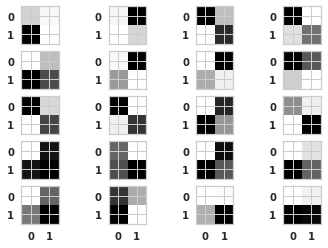

In [ ]:
display_images(latent_concepts[0:20], None, None)

In [ ]:
def cluster_latent_vectors_gmm(num_clusters: int,
                               latent_vectors: np.ndarray,
                               exp_config: ExperimentConfig
                               ):
    gm = GaussianMixture(n_components=num_clusters, random_state=0)
    cluster_labels = gm.fit_predict(latent_vectors)
    cluster_centers = gm.means_
    posterior = gm.predict_proba(latent_vectors)

    return cluster_centers, cluster_labels, posterior

In [ ]:
cluster_centers_concepts, cluster_labels_concepts, posterior_concepts = cluster_latent_vectors_gmm(30,
                                                                                                   np.reshape(latent_concepts,
                                                                                                              (latent_concepts.shape[0], 4)),
                                                                                                   _exp_config,)

In [ ]:
cluster_centers_concepts.shape

(30, 4)

In [ ]:
cluster_centers_concepts_reshaped = cluster_centers_concepts.reshape((30, 2, 2))

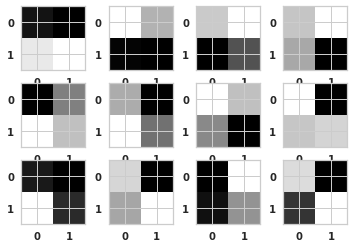

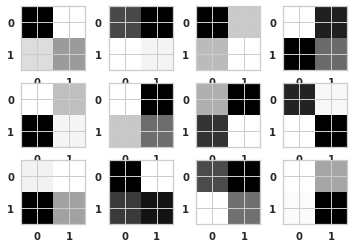

In [ ]:
display_images(cluster_centers_concepts_reshaped[0:12], None, None)
display_images(cluster_centers_concepts_reshaped[12:24], None, None)

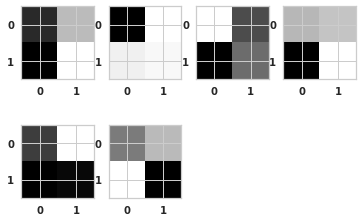

In [ ]:
display_images(cluster_centers_concepts_reshaped[24:], None, None)

In [ ]:
repeated_concepts = np.zeros((cluster_centers_concepts.shape[0], 4, 4))
for cluster_num_concept in range(cluster_centers_concepts_reshaped.shape[0]):
    repeated_concept = np.hstack([cluster_centers_concepts_reshaped[cluster_num_concept],
                                  cluster_centers_concepts_reshaped[cluster_num_concept]])
    repeated_concepts[cluster_num_concept] = np.vstack([repeated_concept, repeated_concept])

In [ ]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                    exp_config=_exp_config,
                    model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                    num_epochs=1,
                    sess=sess,
                    test_data_iterator=None,
                    train_val_data_iterator=None
                    )
    feature_names, concepts_decoded, features_dict  = decode_and_get_features(model,
                                               repeated_concepts.reshape((repeated_concepts.shape[0], 16)),
                                               _exp_config.BATCH_SIZE)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

In [ ]:
concepts_decoded = np.squeeze(concepts_decoded)

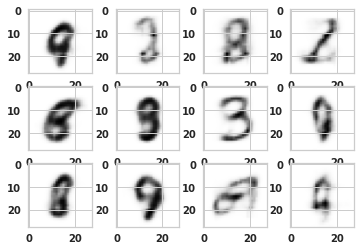

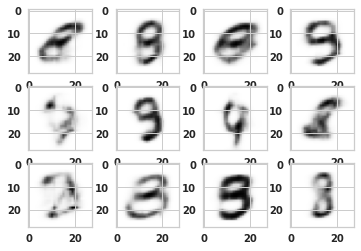

In [ ]:
display_images(concepts_decoded[0:12], None, None)
display_images(concepts_decoded[12:24], None, None)

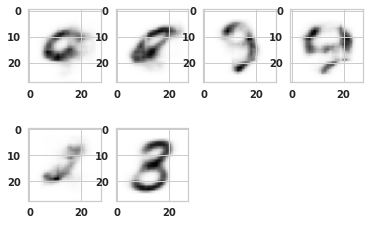

In [ ]:
display_images(concepts_decoded[24:], None, None)

In [ ]:
import pandas
pandas.set_option('display.max_rows', 500)

In [ ]:
print([c for c in df.columns])

['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4', 'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'mu_10', 'mu_11', 'mu_12', 'mu_13', 'mu_14', 'mu_15', 'sigma_0', 'sigma_1', 'sigma_2', 'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8', 'sigma_9', 'sigma_10', 'sigma_11', 'sigma_12', 'sigma_13', 'sigma_14', 'sigma_15', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'z_10', 'z_11', 'z_12', 'z_13', 'z_14', 'z_15', 'predicted_proba_0', 'predicted_proba_1', 'predicted_proba_2', 'predicted_proba_3', 'predicted_proba_4', 'predicted_proba_5', 'predicted_proba_6', 'predicted_proba_7', 'predicted_proba_8', 'predicted_proba_9', 'cluster_level_1', 'distance_0', 'distance_1', 'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6', 'distance_7', 'distance_8', 'distance_9', 'confidence_0', 'confidence_1', 'confidence_2', 'confidence_3', 'confidence_4', 'confidence_5', 'confidence_6', 'confidence_7', 'confidence_8', 'confidence_9', 'cluster

In [ ]:
df[df["cluster_level_1"] == 0][["label","cluster_level_1", "distance_0"]].describe()

label  cluster_level_1   distance_0
count  5918.000000           5918.0  5918.000000
mean      5.912808              0.0     3.936214
std       0.670362              0.0     0.709666
min       0.000000              0.0     1.568050
25%       6.000000              0.0     3.431053
50%       6.000000              0.0     3.899128
75%       6.000000              0.0     4.401068
max       9.000000              0.0     6.459423

In [ ]:
df[(df["cluster_level_1"] == 0) & (df["distance_0"] < 4 )][["label","cluster_level_1", "distance_0"]].groupby(["label"]).count()

cluster_level_1  distance_0
label                             
0                    9           9
1                    1           1
2                    2           2
3                    1           1
4                    6           6
5                   13          13
6                 3219        3219
8                    6           6
9                    1           1

In [ ]:
df[(df["cluster_level_1"] == 0) & (df["distance_0"] )][["label","cluster_level_1", "distance_0"]].groupby(["label"]).count()

cluster_level_1  distance_0
label                             
0                   47          47
1                   16          16
2                   14          14
3                    8           8
4                   32          32
5                   68          68
6                 5703        5703
7                    5           5
8                   22          22
9                    3           3

In [ ]:
df[(df["cluster_level_1"] == 0) & (df["distance_0"] < 4 )][["label","cluster_level_1", "distance_0"]].groupby(["label"]).mean()

cluster_level_1  distance_0
label                             
0                    0    3.559120
1                    0    3.803544
2                    0    3.703817
3                    0    3.991727
4                    0    3.519147
5                    0    3.746044
6                    0    3.418835
8                    0    3.589513
9                    0    3.691044

In [ ]:
manual_labels

[6, 5, 9, 3, 7, 8, 2, 1, 0, 4]

In [ ]:
cluster = 0
for i in range(10):
    max_direction = np.argmax(abs(cluster_centers[cluster] - cluster_centers[i]))
    print(f"{cluster} {i} {max_direction}")

0 0 0
0 1 8
0 2 6
0 3 6
0 4 1
0 5 10
0 6 6
0 7 10
0 8 0
0 9 1


In [ ]:
cluster = 1
for i in range(10):
    max_direction = np.argmax(abs(cluster_centers[cluster] - cluster_centers[i]))
    print(f"{cluster} {i} {max_direction}")

1 0 8
1 1 0
1 2 6
1 3 6
1 4 8
1 5 6
1 6 8
1 7 8
1 8 10
1 9 4


In [ ]:
cluster = 2
for i in range(10):
    max_direction = np.argmax(abs(cluster_centers[cluster] - cluster_centers[i]))
    print(f"{cluster} {i} {max_direction}")

2 0 6
2 1 6
2 2 0
2 3 4
2 4 8
2 5 4
2 6 8
2 7 8
2 8 9
2 9 8


In [ ]:
cluster = 3
for i in range(10):
    max_direction = np.argmax(abs(cluster_centers[cluster] - cluster_centers[i]))
    print(f"{cluster} {i} {max_direction}")

3 0 6
3 1 6
3 2 4
3 3 0
3 4 11
3 5 10
3 6 4
3 7 10
3 8 2
3 9 4


In [ ]:
cluster = 4
for i in range(10):
    max_direction = np.argmax(abs(cluster_centers[cluster] - cluster_centers[i]))
    print(f"{cluster} {i} {max_direction}")

4 0 1
4 1 8
4 2 8
4 3 11
4 4 0
4 5 11
4 6 2
4 7 12
4 8 9
4 9 12


In [ ]:
cluster = 5
for i in range(10):
    max_direction = np.argmax(abs(cluster_centers[cluster] - cluster_centers[i]))
    print(f"{cluster} {i} {max_direction}")

5 0 10
5 1 6
5 2 4
5 3 10
5 4 11
5 5 0
5 6 4
5 7 12
5 8 10
5 9 4


In [ ]:
manual_labels.index(1)

7

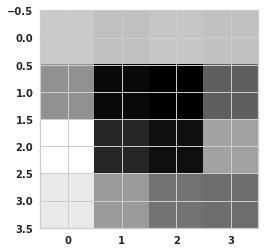

In [ ]:
plt.imshow(cluster_centers_reshaped[7])

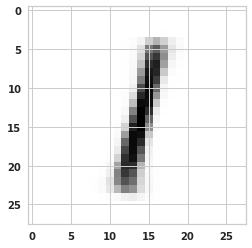

In [ ]:
plt.imshow(np.squeeze(decoded_images[7:8]))


# Define function trace_dim

In [ ]:
def trace_dim(exp_config, mu, num_trace_steps,  dim):    
    z = np.zeros([num_trace_steps , exp_config.Z_DIM])
    for i in range(num_trace_steps):
        z[i] = mu
    z_min =  -5
    z_max = 5
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, dim ] = alpha_i * z_min + (1 - alpha_i) * z_max
    return z
    
    

In [ ]:
# num_trace_steps = 36
# tf.reset_default_graph()
# with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

#     model = get_model(dao = _exp_config.dao,
#       exp_config=_exp_config,
#       model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
#       num_epochs=1,
#       sess=sess,
#       test_data_iterator=None,
#       train_val_data_iterator=None)

#     # checkpoint_counter = model.load_from_checkpoint()
#     # print("Check point counter", checkpoint_counter)
#     num_latent_vectors = 0
#     total_latent_vectors = _exp_config.Z_DIM * num_trace_steps
#     if total_latent_vectors < _exp_config.BATCH_SIZE:
#         total_latent_vectors = _exp_config.BATCH_SIZE
#     z = np.zeros([total_latent_vectors, _exp_config.Z_DIM])
#     for dimension in range(_exp_config.Z_DIM):
#         traced_from_to = trace_dim(_exp_config, cluster_centers_reshaped[0], num_trace_steps, dimension)
#         for i in range(num_trace_steps):
#             z[ num_latent_vectors, :] = traced_from_to[i]
#             num_latent_vectors += 1
#     reconstructed_images_trace_from_zero = decode(model, z, _exp_config.BATCH_SIZE)
    

In [ ]:
num_trace_steps = 36
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    model = get_model(dao = _exp_config.dao,
      exp_config=_exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    num_latent_vectors = 0
    total_latent_vectors = _exp_config.dao.num_classes * _exp_config.Z_DIM * num_trace_steps
    if total_latent_vectors < _exp_config.BATCH_SIZE:
        total_latent_vectors = _exp_config.BATCH_SIZE
    z = np.zeros([total_latent_vectors, _exp_config.Z_DIM])
    for d in range(10):
        for dimension in range(_exp_config.Z_DIM):
            traced_from_to = trace_dim(_exp_config, cluster_centers[manual_labels.index(d)], num_trace_steps, dimension)
            for i in range(num_trace_steps):
                z[ num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
    reconstructed_images = decode(model, z, _exp_config.BATCH_SIZE)


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

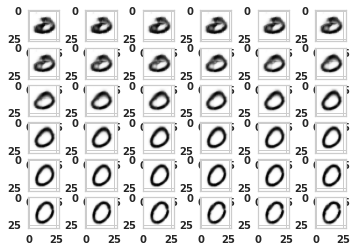

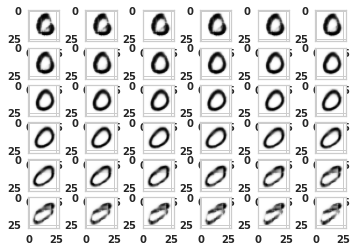

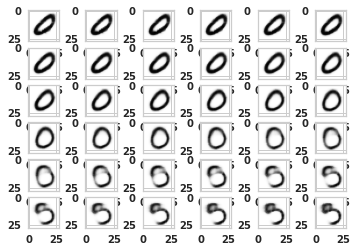

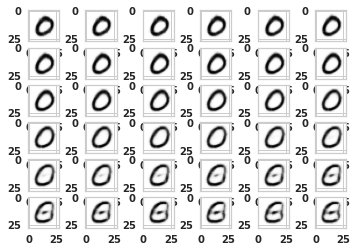

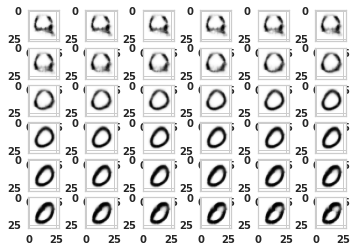

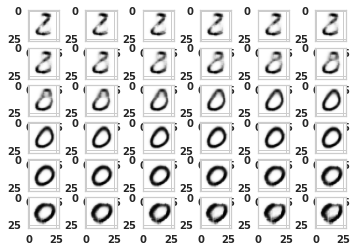

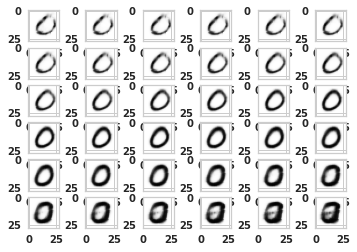

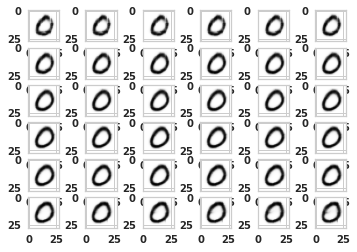

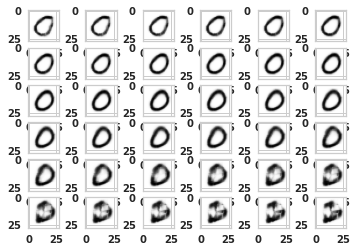

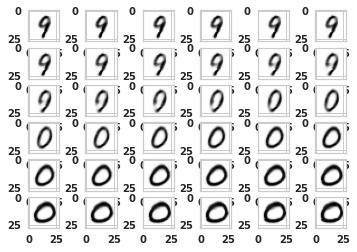

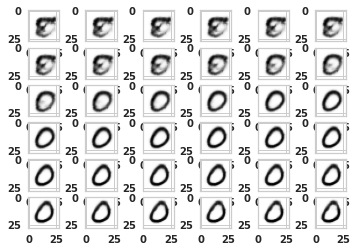

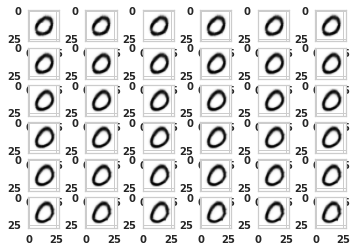

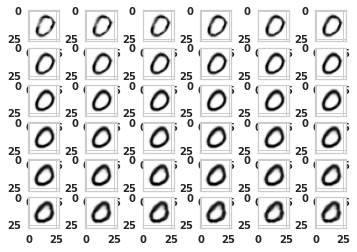

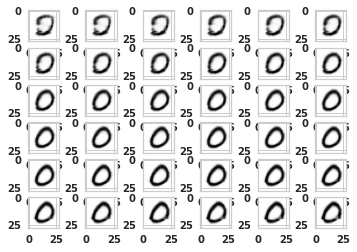

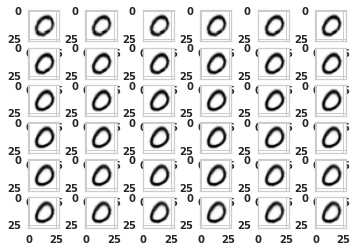

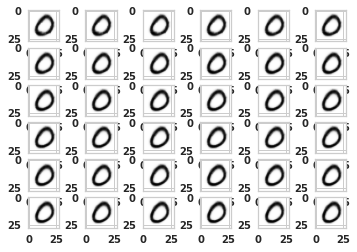

In [ ]:
d = 0
from sklearn.metrics import mean_squared_error as mse
find_similarity_with_digit = 5
num_images_plotted = d * _exp_config.Z_DIM * num_trace_steps
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"

mses_2d = []
for dim in range(_exp_config.Z_DIM):
    fig = plt.figure()
    # fig.suptitle(title_string.format(dim, d))
    mses = []
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6 ,6, i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]))
        
        # mses.append(mse( np.squeeze(reconstructed_images_mean[find_similarity_with_digit]),
        #                 np.squeeze(reconstructed_images[i])
        #                 )
        #)
#    mses_2d.append(mses)
    num_images_plotted += num_trace_steps
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

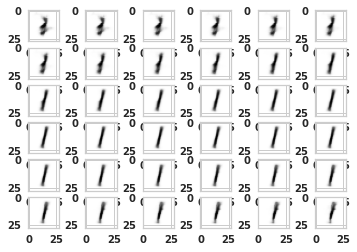

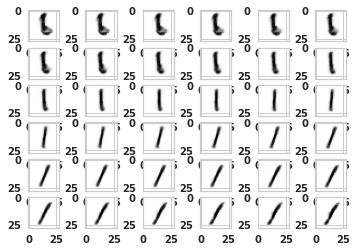

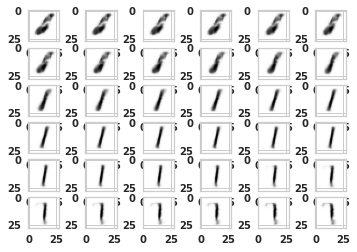

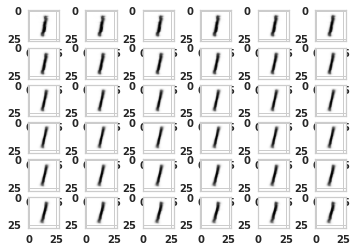

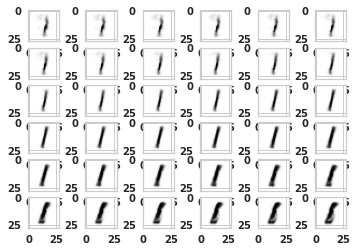

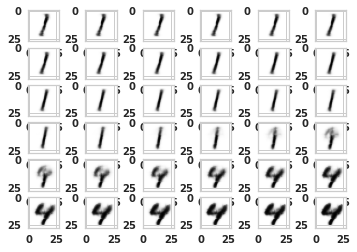

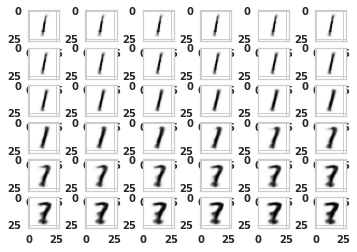

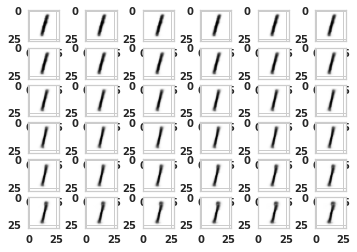

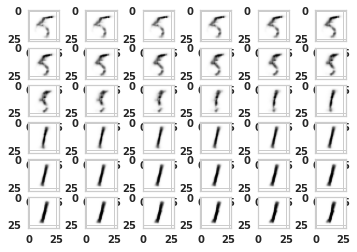

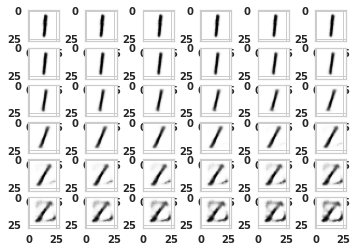

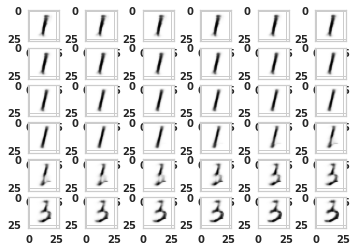

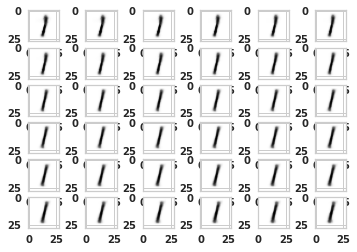

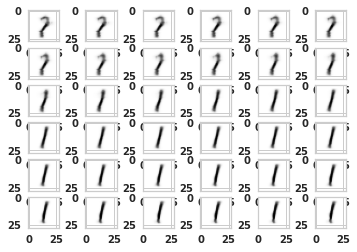

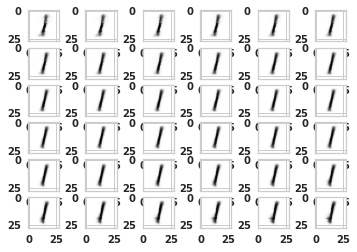

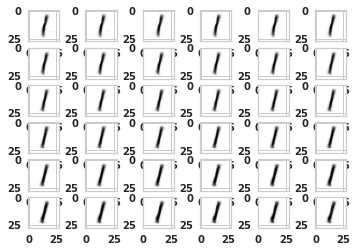

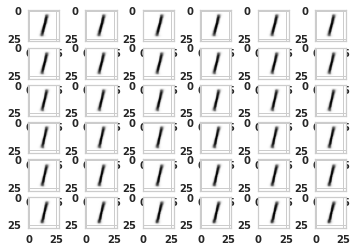

In [ ]:
d = 1
from sklearn.metrics import mean_squared_error as mse
find_similarity_with_digit = 5
num_images_plotted = d * _exp_config.Z_DIM * num_trace_steps
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"

mses_2d = []
for dim in range(_exp_config.Z_DIM):
    fig = plt.figure()
    # fig.suptitle(title_string.format(dim, d))
    mses = []
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6 ,6, i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]))
        
        # mses.append(mse( np.squeeze(reconstructed_images_mean[find_similarity_with_digit]),
        #                 np.squeeze(reconstructed_images[i])
        #                 )
        #)
#    mses_2d.append(mses)
    num_images_plotted += num_trace_steps
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

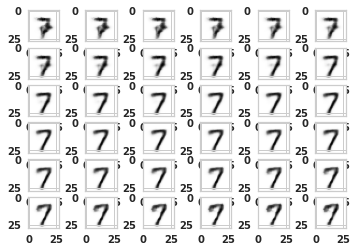

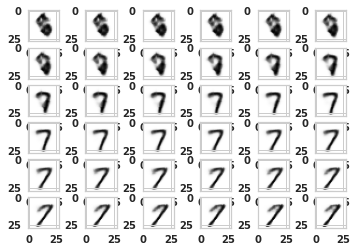

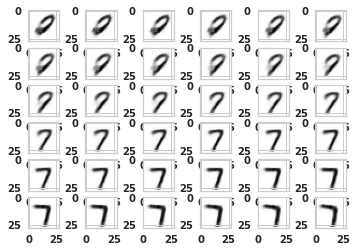

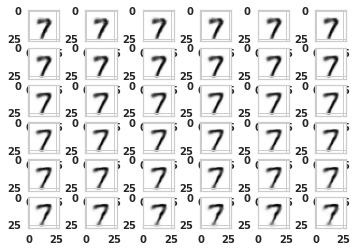

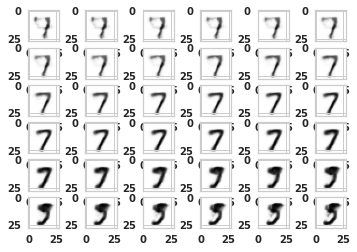

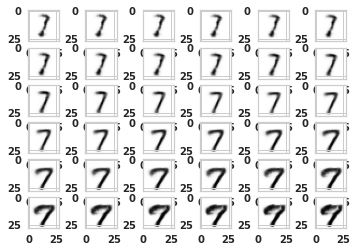

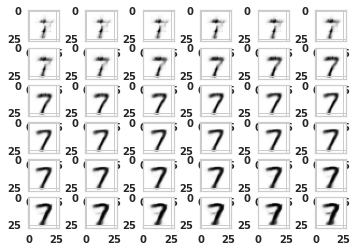

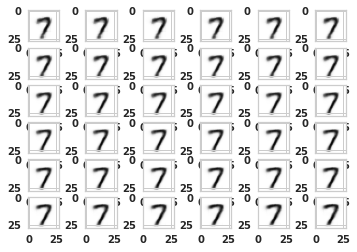

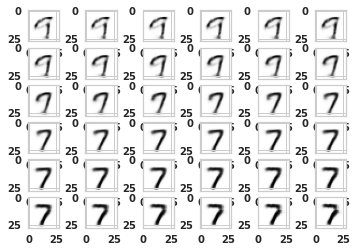

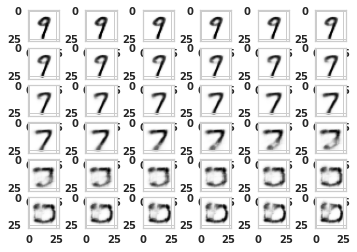

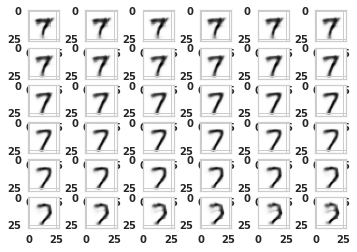

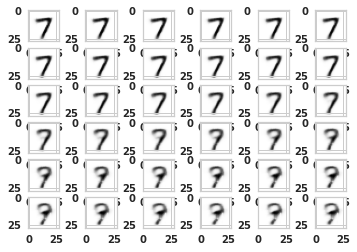

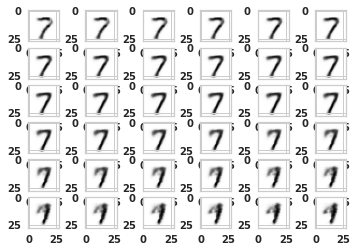

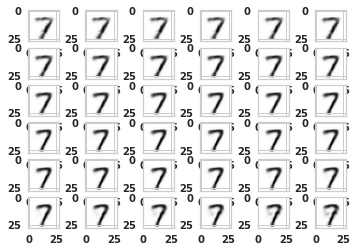

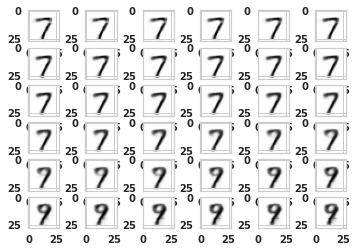

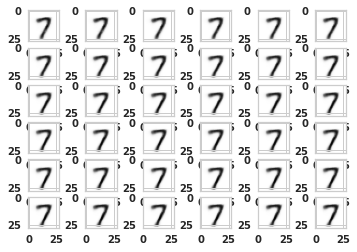

In [ ]:
d = 7
from sklearn.metrics import mean_squared_error as mse
find_similarity_with_digit = 5
num_images_plotted = d * _exp_config.Z_DIM * num_trace_steps
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"

mses_2d = []
for dim in range(_exp_config.Z_DIM):
    fig = plt.figure()
    # fig.suptitle(title_string.format(dim, d))
    mses = []
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6 ,6, i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]))
        
        # mses.append(mse( np.squeeze(reconstructed_images_mean[find_similarity_with_digit]),
        #                 np.squeeze(reconstructed_images[i])
        #                 )
        #)
#    mses_2d.append(mses)
    num_images_plotted += num_trace_steps
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

In [ ]:
cluster_centers[4]

array([-0.04035421, -0.9222638 , -0.92452544,  0.25461939,  0.24694692,
       -0.59268231, -0.46464038, -0.19476671, -0.55830265,  0.66755465,
        0.2841719 ,  1.69843551,  1.40648047, -0.18477235,  1.15498244,
        0.11462847])

In [ ]:
cluster_centers[4].reshape((4,4))

array([[-0.04035421, -0.9222638 , -0.92452544,  0.25461939],
       [ 0.24694692, -0.59268231, -0.46464038, -0.19476671],
       [-0.55830265,  0.66755465,  0.2841719 ,  1.69843551],
       [ 1.40648047, -0.18477235,  1.15498244,  0.11462847]])

In [ ]:
manual_labels.index(7)

4

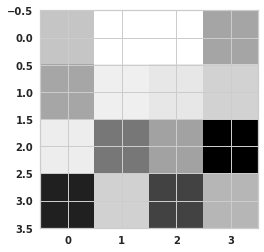

In [ ]:
plt.imshow(cluster_centers_reshaped[4])

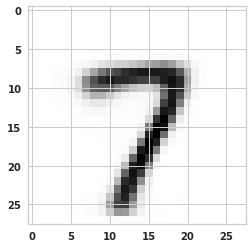

In [ ]:
plt.imshow(np.squeeze(decoded_images[4:5]))

In [ ]:
manual_labels.index(9)

2

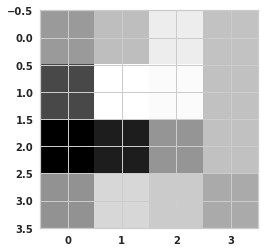

In [ ]:
plt.imshow(cluster_centers_reshaped[2])

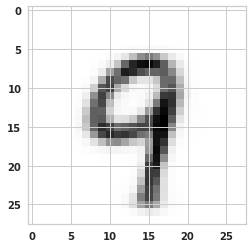

In [ ]:
plt.imshow(np.squeeze(decoded_images[2:3]))

In [ ]:
from clearn.utils.data_loader import translate_random

In [ ]:
from random import randint
def translate(im, num_pixels, direction):
    im = im.reshape(28, 28)
    if num_pixels > 0:
        if direction == 0:
            # move down
            im = np.pad(im, pad_width=((num_pixels, 0), (0, 0)), mode="edge")[0:-num_pixels]
        elif direction == 1:
            # move up
            im = np.pad(im, pad_width=((0, num_pixels), (0, 0)), mode="edge")[num_pixels:]
        elif direction == 2:
            # move left
            im = np.pad(im, pad_width=( (0, 0), (0, num_pixels)), mode="edge")[:, num_pixels:]
        elif direction == 3:
            im = np.pad(im, pad_width=( (0, 0), (num_pixels, 0)), mode="edge")[:, 0:-num_pixels]
    im = im.reshape(1, 784)
    return im

# Translate images by 4 pixels

In [ ]:
translated = np.apply_along_axis(translate,
                                 1,
                                 decoded_images.reshape(decoded_images.shape[0], 784),
                                 num_pixels = 4,
                                 direction=0)
translated = translated.reshape((decoded_images.shape[0], 28, 28, 1))

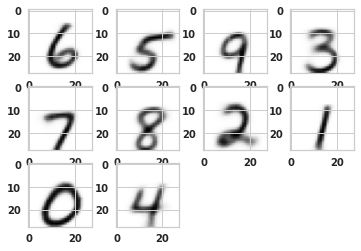

In [ ]:
display_images(translated, None, None)

In [ ]:
from clearn.analysis.encode_decode import encode

In [ ]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    model = get_model(dao = _exp_config.dao,
      exp_config=_exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    translated_lv = encode(model, translated, _exp_config.BATCH_SIZE, _exp_config.Z_DIM)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 256), (7, 7, 128), (4, 4, 128), (4, 4, 64), 16]
[256, 128, 128, 64]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_256_128_128_64/Exp_64_128_128_256_16_ELBOW_50/trained_models/SemiSupervisedClassifierMnist.model-70

ValueError: ignored

In [ ]:
def encode(model, images, batch_size, z_dim):
    """
    Encode the given set of images using the model provided
    :param model: Model Object
    :param images: `ndarray` of images
    :param batch_size: batch_size to be used while encoding
    :param z_dim: latent vector dimension
    :return: `ndarray` of latent vectors corresponding  to images
    """
    latent_vectors = np.zeros([len(images), z_dim])
    num_images = images.shape[0]
    num_batches = num_images // batch_size
    for batch_num in range(num_batches):
        mu, sigma, z, _ = model.encode(images[batch_num * batch_size: (batch_num + 1) * batch_size])
        latent_vectors[batch_num * batch_size: (batch_num + 1) * batch_size] = z
    left_out = num_images % batch_size
    if left_out != 0:
        feature_dimension = [batch_size, model.dao.image_shape[0], model.dao.image_shape[1], model.dao.image_shape[2]]
        last_batch = np.zeros(feature_dimension)
        last_batch[0:left_out] = images[num_batches * batch_size:]
        mu, sigma, z, _ = model.encode(last_batch)
        latent_vectors[num_batches * batch_size:] = z[0:left_out]
    return latent_vectors


In [ ]:
cluster_no = 0
plt.plot(translated_lv[cluster_no])
plt.plot(cluster_centers[cluster_no])

In [ ]:
cluster_no = 1
plt.plot(translated_lv[cluster_no])
plt.plot(cluster_centers[cluster_no])

In [ ]:
cluster_no = 2
plt.plot(translated_lv[cluster_no])
plt.plot(cluster_centers[cluster_no])

In [ ]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    model = get_model(dao = _exp_config.dao,
      exp_config=_exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    reconstructed_cluster_centers = encode(model, decoded_images, _exp_config.BATCH_SIZE, _exp_config.Z_DIM)

In [ ]:
cluster_no = 0
plt.plot(reconstructed_cluster_centers[cluster_no])
plt.plot(cluster_centers[cluster_no])

In [ ]:
cluster_no = 1
plt.plot(translated_lv[cluster_no])
plt.plot(cluster_centers[cluster_no])

In [ ]:
tf.reset_default_graph()
reconstructed_cluster_centers_1 = np.zeros((100, 16))
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    model = get_model(dao = _exp_config.dao,
      exp_config=_exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    for i in range(100):
        reconstructed_cluster_centers_1[i] = encode(model,
                                                    decoded_images,
                                                    _exp_config.BATCH_SIZE,
                                                    _exp_config.Z_DIM)[0]



In [ ]:
# plt.plot((decoded_images_1[:, 0, 0, 0]).flatten())
std = np.std(reconstructed_cluster_centers_1, axis=0)
mean = np.mean(reconstructed_cluster_centers_1, axis=0)
print(std.shape)
print(np.min(decoded_images), np.max(decoded_images))


In [ ]:
plt.imshow(np.squeeze(std.reshape((4,4))))
plt.colorbar()

In [ ]:
plt.imshow(mean.reshape((4,4)))

In [ ]:
print(np.min(reconstructed_cluster_centers_1), np.max(reconstructed_cluster_centers_1))


In [ ]:
print(mean)

In [ ]:
print(std)

In [ ]:
from copy import deepcopy

In [ ]:
def change_dim(mean, std, dim):
    num_std = 4
    mean_1 = deepcopy(mean)
    mean_2 = deepcopy(mean)
    mean_1[dim] = mean_1[dim] + num_std * std[dim]
    mean_2[dim] = mean_2[dim] - num_std * std[dim]
    return mean_1, mean_2

lvs = np.zeros((32, 16))
for dim in range(16):
    lvs[dim * 2], lvs[dim * 2 + 1] = change_dim(mean, std, dim)



In [ ]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None)

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    images_1 = decode(model,
                      lvs,
                      _exp_config.BATCH_SIZE)



In [ ]:
display_images(images_1[0:12], None, None)

In [ ]:
display_images(images_1[12:], None, None)

In [ ]:
display_images(images_1[24:], None, None)

In [ ]:
plt.plot(mean)
plt.plot(lvs[2])
plt.plot(lvs[3])

# Trace dim for digit 6

In [ ]:
d = 6
from sklearn.metrics import mean_squared_error as mse
find_similarity_with_digit = 5
num_images_plotted = d * _exp_config.Z_DIM * num_trace_steps
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"

mses_2d = []
for dim in range(_exp_config.Z_DIM):
    fig = plt.figure()
    # fig.suptitle(title_string.format(dim, d))
    mses = []
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6 ,6, i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]))
        
        # mses.append(mse( np.squeeze(reconstructed_images_mean[find_similarity_with_digit]),
        #                 np.squeeze(reconstructed_images[i])
        #                 )
        #)
#    mses_2d.append(mses)
    num_images_plotted += num_trace_steps
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

In [ ]:
cluster_no = 0
plt.figure(figsize=(20,10))
plt.plot(translated_lv[cluster_no])
plt.plot(cluster_centers[cluster_no])
plt.legend(["translated", "original"])

In [ ]:
for cluster_no in range(10):
    print(f"Cluster no {cluster_no}  Label {manual_labels[cluster_no]}")
    ad = abs(translated_lv[cluster_no] - cluster_centers[cluster_no])
    print(ad)
    print(np.argsort(-ad))

In [ ]:
plt.plot(mean)
